<a href="https://colab.research.google.com/github/IshaShah27/dfg-humanrights/blob/master/IS_330_2_viz_202011003.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Installations

In [1]:
! pip install chart_studio

     |████████████████████████████████| 64 kB 1.8 MB/s 


In [2]:
import pandas as pd
import itertools
import spacy
import numpy as np
import chart_studio
import chart_studio.plotly as py
import chart_studio.tools as tls
import plotly.graph_objects as go
import re
import itertools
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas(desc="progress bar")

In [3]:
pd.reset_option('all')
pd.set_option('display.max_colwidth', None)


: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.



/usr/local/lib/python3.7/dist-packages/pandas/_config/config.py:622: FutureWarning:


: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.




## Mount drives

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
# authenticate to BigQuery
# if you do not have access, please contact Lawrence at lcl2152@columbia.edu

from google.colab import auth
auth.authenticate_user()

project_id = 'dfg-cohrv-314114'

## Import crosswalks

In [6]:
# import sics company name - ticker csv
df_ticker = pd.read_csv('/content/gdrive/MyDrive/DFG Cost of Human Rights Violations/Datasets/sasb_label_20210128/sics_2021_03_01_US_ONLY.csv', usecols=["company_ticker", "company_name"])
df_ticker.head()

,company_ticker,company_name
0,EEIG,024 Pharma Inc
1,TXG,10X Genomics Inc
2,YI,111 Inc
3,PIH,"1347 Property Insurance Holdings, Inc."
4,ONCP,141 Capital Inc


In [7]:
# load and join industry descriptions
df_ind_desc = pd.read_csv('/content/gdrive/MyDrive/DFG Cost of Human Rights Violations/Datasets/sasb_label_20210128/industry.csv')
df_ind_desc = df_ind_desc[['INDUSTRY_ID', 'INDUSTRY_NAME']]
df_ind_desc.columns = ['primary_industry_id', 'primary_industry_desc']

# replace the names with short names
df_ind_desc = df_ind_desc.replace("Electric Utilities & Power Generators", "Elec Utils & Power Gen")
df_ind_desc = df_ind_desc.replace("Electronic Manufacturing Services & Original Design Manufacturing", "Elec Manuf Svcs & Orig Des Manuf")
df_ind_desc = df_ind_desc.replace("Engineering & Construction Services", "Engr & Construction Svcs")
df_ind_desc = df_ind_desc.replace("Oil & Gas – Exploration & Production", "Oil & Gas – Expl & Prod")
df_ind_desc = df_ind_desc.replace("Professional & Commercial Services", "Prof & Comm Svcs")
df_ind_desc = df_ind_desc.replace("Wind Technology & Project Developers", "Wind Tech & Proj Dev")
df_ind_desc = df_ind_desc.replace("Multiline and Specialty Retailers & Distributors", "Multiline and Splty Rtl & Dists")
df_ind_desc = df_ind_desc.replace("Solar Technology & Project Developers", "Solar Tech & Proj Dev")
df_ind_desc.head()

,primary_industry_id,primary_industry_desc
0,CG-AA,"Apparel, Accessories & Footwear"
1,CG-AM,Appliance Manufacturing
2,CG-BF,Building Products & Furnishings
3,CG-EC,E-commerce
4,CG-HP,Household & Personal Products


In [8]:
df_10ks_sics = pd.read_csv('/content/gdrive/MyDrive/DFG Cost of Human Rights Violations/Datasets/10k_clean_text/_0.0 downloaded/usable_10ks_with_sics.csv')
df_10ks_sics['year'] = df_10ks_sics['fy'].astype('str').str[:4]
df_10ks_sics.head()

,filename,filepath,ticker,type,fy,doc_id,id,company_ticker,company_name,isin,naics_code,country,exchange,market_cap,market_cap_category,revenue,primary_industry_id,secondary_industry_id,tertiary_industry_id,is_active,last_modified_date,scope,ticker_display,year
0,STAG_10-K_20121231_0001047469-13-002284.txt,/content/drive/MyDrive/DFG Cost of Human Rights Violations/Datasets/10k_clean_text/_0.0 downloaded/2013Q1/STAG_10-K_20121231_0001047469-13-002284.txt,STAG,10-K,20121231,0001047469-13-002284.txt,135671,STAG,"Stag Industrial, Inc.",US85254J1025,NaN,US,New York,3.575124e+09,Medium Cap,NaN,IF-RE,NaN,NaN,Y,2019-12-13 00:08:25,US,STAG,2012
1,STAG_10-K_20131231_0001047469-14-001398.txt,/content/drive/MyDrive/DFG Cost of Human Rights Violations/Datasets/10k_clean_text/_0.0 downloaded/2014Q1/STAG_10-K_20131231_0001047469-14-001398.txt,STAG,10-K,20131231,0001047469-14-001398.txt,135671,STAG,"Stag Industrial, Inc.",US85254J1025,NaN,US,New York,3.575124e+09,Medium Cap,NaN,IF-RE,NaN,NaN,Y,2019-12-13 00:08:25,US,STAG,2013
2,STAG_10-K_20141231_0001558370-15-000135.txt,/content/drive/MyDrive/DFG Cost of Human Rights Violations/Datasets/10k_clean_text/_0.0 downloaded/2015Q1/STAG_10-K_20141231_0001558370-15-000135.txt,STAG,10-K,20141231,0001558370-15-000135.txt,135671,STAG,"Stag Industrial, Inc.",US85254J1025,NaN,US,New York,3.575124e+09,Medium Cap,NaN,IF-RE,NaN,NaN,Y,2019-12-13 00:08:25,US,STAG,2014
3,STAG_10-K_20151231_0001479094-16-000006.txt,/content/drive/MyDrive/DFG Cost of Human Rights Violations/Datasets/10k_clean_text/_0.0 downloaded/2016Q1/STAG_10-K_20151231_0001479094-16-000006.txt,STAG,10-K,20151231,0001479094-16-000006.txt,135671,STAG,"Stag Industrial, Inc.",US85254J1025,NaN,US,New York,3.575124e+09,Medium Cap,NaN,IF-RE,NaN,NaN,Y,2019-12-13 00:08:25,US,STAG,2015
4,STAG_10-K_20161231_0001479094-17-000005.txt,/content/drive/MyDrive/DFG Cost of Human Rights Violations/Datasets/10k_clean_text/_0.0 downloaded/2017Q1/STAG_10-K_20161231_0001479094-17-000005.txt,STAG,10-K,20161231,0001479094-17-000005.txt,135671,STAG,"Stag Industrial, Inc.",US85254J1025,NaN,US,New York,3.575124e+09,Medium Cap,NaN,IF-RE,NaN,NaN,Y,2019-12-13 00:08:25,US,STAG,2016


In [ ]:
# IS commented out - df_num_paras stores the document with the number of paragraphs in it
# df_num_paras = pd.read_csv('/content/gdrive/MyDrive/DFG Cost of Human Rights Violations/Datasets/10k_clean_text/_1.0 hypothesis testing/10ks_para_sics_tot_para.csv')
# df_num_paras.shape

(35147, 2)

In [9]:
# calculate and join industry-level ticker counts
df_ind_total = df_10ks_sics.groupby(['year', 'primary_industry_id'])\
                .agg({'ticker_display': pd.Series.nunique}).reset_index()
df_ind_total.columns = ['year', 'primary_industry_id', 'ind_tot_tkr']
df_ind_total.head()  # dataframe that contains industries aggregated by year with the total occurances of the terms in the heuristics

,year,primary_industry_id,ind_tot_tkr
0,2000,CG-MR,1
1,2001,CG-MR,1
2,2001,TC-HW,1
3,2002,CG-MR,1
4,2002,TC-TL,1


## Define heuristic

In [10]:
# label for heuristic
GIC_HEURISTIC_ID = '330.2'
GIC_TOPIC_DESC = 'diversity'

# define terms for the relevant contexts
any_valid_chars = '([A-Za-z\d%,;\'\\\"\s])*'
diversity_context = '(\sdiverse\s|\sdiversity\s)'
relevant_context = '(women|female|minorities|\scolor\s|ethnicit|\srace\s|\sracism\s|racial|\ssexual\sorientation|gender|disabili|military.+veteran|veteran.+military|protected.+veteran|veteran.+protected|veteran status)' 

# UR version
worker_context = '(worker\s|workforce|outreach|training|director|)'
# IS version
worker_context = '(worker\s|workforce|outreach|training|director|manager|hiring|worker|employee)'

# use below if any 2 out of 3 contexts is sufficient - IS version
terms_to_include = [any_valid_chars+diversity_context+any_valid_chars\
                    +relevant_context+any_valid_chars, 
                    any_valid_chars+relevant_context+any_valid_chars\
                    +diversity_context+any_valid_chars, 

                    any_valid_chars+diversity_context+any_valid_chars\
                    +worker_context+any_valid_chars, 
                    any_valid_chars+worker_context+any_valid_chars\
                    +diversity_context+any_valid_chars,

                    any_valid_chars+worker_context+any_valid_chars\
                    +relevant_context+any_valid_chars,
                    any_valid_chars+relevant_context+any_valid_chars\
                    +worker_context+any_valid_chars]

# use below if 3 out of 3 contexts needed
# terms_to_include = [any_valid_chars+diversity_context+any_valid_chars\
#                     +relevant_context+any_valid_chars+worker_context+any_valid_chars,
#                     any_valid_chars+diversity_context+any_valid_chars\
#                     +worker_context+any_valid_chars+relevant_context+any_valid_chars,
#                     any_valid_chars+relevant_context+any_valid_chars\
#                     +worker_context+any_valid_chars+diversity_context+any_valid_chars,
#                     any_valid_chars+relevant_context+any_valid_chars\
#                     +diversity_context+any_valid_chars+worker_context+any_valid_chars,
#                     any_valid_chars+worker_context+any_valid_chars\
#                     +relevant_context+any_valid_chars+diversity_context+any_valid_chars,
#                     any_valid_chars+worker_context+any_valid_chars\
#                     +diversity_context+any_valid_chars+relevant_context+any_valid_chars]


terms_to_exclude = ['diverse client', 'diverse customer', 'energy diversity', 
                    'dna', 'rna', 'diverse client', 'diverse customer',
                    'divers.+investmen', 'investmen.+divers',
                    'diverse skills', 'footwear', 'shoes', 'clinical', 
                    'decor', 'diverse skills', 'diverse need']

heuristics = [
              {'include': terms_to_include,
               'exclude':terms_to_exclude}       
              ]

# set up apply_heuristics method - this takes as input the text and outputs a 1
# if the text is relevant and 0 if the text is irrelevant
# this function is only used if NOT using GBQ
def apply_heuristics(text, terms_to_include, terms_to_exclude):

  # lowercase text
  text = text.lower()

  # replace line breaks
  text = text.replace('\n', ' ')

  terms_to_include = terms_to_include[0] if len(terms_to_include) == 1 else '|'.join(terms_to_include)
  terms_to_exclude = terms_to_exclude[0] if len(terms_to_exclude) == 1 else '|'.join(terms_to_exclude)

  if (len(terms_to_include) == 0 or re.search(terms_to_include, text)) \
      and (len(terms_to_exclude) == 0 or (not re.search(terms_to_exclude, text))):
      return 1
  else:
    return 0

# set up dataframe to store results
# Training Data
# df_result.to_csv('/content/drive/MyDrive/DFG Cost of Human Rights Violations/Datasets/10k_clean_text/_1.0 hypothesis testing/10ks_sics_gic_'+gic+'_'+GIC_TOPIC_DESC+'_full.csv', index=False)
# df_result[['id', 'ticker_display', 'primary_industry_id', 'text']].sample(100).to_csv('/content/drive/MyDrive/DFG Cost of Human Rights Violations/Datasets/10k_clean_text/_1.0 hypothesis testing/10ks_sics_gic_'+gic+'_'+GIC_TOPIC_DESC+'_sample.csv', index=False)

In [11]:
# https://cloud.google.com/resource-manager/docs/creating-managing-projects

# give heuristic ID
GIC_HEURISTIC_ID = '330.2'

# don't worry about case sensitivity. it is taken care of in the SQL statement
terms_to_include = heuristics[0]['include']
terms_to_exclude = heuristics[0]['exclude']

# combine terms to include into a regex statement
if len(terms_to_include) > 0:
  terms_to_include = terms_to_include[0] if len(terms_to_include) == 1 else '|'.join(terms_to_include)
else:
  terms_to_include = '~'

# combine terms to exclude into a regex statement
if len(terms_to_exclude) > 0:  
  terms_to_exclude = terms_to_exclude[0] if len(terms_to_exclude) == 1 else '|'.join(terms_to_exclude)
else:
  terms_to_exclude = '~'

# retrieve positive results
df_result_pos = pd.io.gbq.read_gbq(
  '''
  SELECT *
  FROM `dfg_cohrv.10ks_para_sics`
  WHERE 
    REGEXP_CONTAINS(text, r"(?i)('''+terms_to_include+''')") 
    AND NOT REGEXP_CONTAINS(text, r"(?i)('''+terms_to_exclude+''')")
  '''
, project_id=project_id)

# retrieve negative results - these are just to make sure that the 
# exclusion criteria didn't take out too many terms, and is therefore just a 
# sample of the excluded
df_result_neg = pd.io.gbq.read_gbq(
  '''
  WITH t AS
  (
    SELECT *
    FROM `dfg_cohrv.10ks_para_sics`
    WHERE 
      REGEXP_CONTAINS(text, r"(?i)('''+terms_to_include+''')") 
      AND REGEXP_CONTAINS(text, r"(?i)('''+terms_to_exclude+''')")
  )
  SELECT * FROM t
  WHERE RAND() < 100/(SELECT COUNT(*) FROM t)  
  '''
, project_id=project_id)

df_result_pos['gic_heuristic_id'] = GIC_HEURISTIC_ID
df_result_neg['gic_heuristic_id'] = GIC_HEURISTIC_ID

df_result_pos = df_result_pos[['gic_heuristic_id', 'id', 'ticker_display', 
                               'primary_industry_id', 'text']]

# look over df_result_neg just to make sure that the negative criteria 
# did not kick out too many paragraphs
df_result_neg = df_result_neg[['gic_heuristic_id', 'id', 'ticker_display', 
                               'primary_industry_id', 'text']]

In [12]:
# # This applies the heuristic in the non-GBQ way - obsolete? - commented out by IS
# df_result = pd.DataFrame()
# df_tmp = df_result_pos.copy()
# for h in heuristics[1:]:
#   df_tmp['result'] = df_tmp['text'].progress_apply(lambda x: \
#                         apply_heuristics(x, h['include'], h['exclude']))
#   df_tmp = df_tmp[df_tmp['result'] == 1]
# df_result = pd.concat((df_result, df_tmp))

In [12]:
# IS addition:
df_result = df_result_pos
df_result['result'] = 1

# Original starts here
GIC_HEURISTIC_ID = '330.2'
MIN_FISCAL_YEAR = '2013'
MAX_FISCAL_YEAR = '2020'

# include additional columns
df_result[['yr_qtr', 'ticker', 'type', 'fye', 'doc_id', 'p_id']] = df_result['id'].str.split('_', expand=True)
df_result['sector'] = df_result['primary_industry_id'].str[:2]
df_result['year'] = df_result['fye'].str[:4]

# keep 2013-2020 fiscal year data
df_result = df_result[(df_result['year'] >= MIN_FISCAL_YEAR) & (df_result['year'] <= MAX_FISCAL_YEAR)]

In [14]:
# # load and join number of paragraphs by doc_id
# # why do we need to know number of paragraphs? Not using this measure anymore
# # commented out by IS
# df_result = pd.merge(left=df_result, right=df_num_paras, on='doc_id')

# **Getting all the paragraphs that contain diversity terms for every company, by year**

In [13]:
# merge on industry and company names
df_paras = df_result[["year", "ticker_display", "primary_industry_id", "text", "ticker", "doc_id", "p_id"]]
df_paras = pd.merge(left=df_paras, right=df_ind_desc, on='primary_industry_id')
df_paras = df_paras.merge(df_ticker, left_on='ticker_display', right_on='company_ticker')
df_paras = df_paras.drop(columns=["ticker_display", "company_ticker", "ticker"])

# drop duplicate paragraphs in same 10-K
df_paras = df_paras.drop_duplicates(subset=["year","text","doc_id"])
df_paras.head()

,year,primary_industry_id,text,doc_id,p_id,primary_industry_desc,company_name
0,2017,CG-HP,The Company's success largely depends upon its ability to attract hire and retain its senior management team other key employees and a highly skilled and diverse workforce as well as effectively implement succession planning for its senior management team and as such the Company's inability to do so could adversely affect the Company's business prospects results of operations financial condition and/or cash flows.,0000887921-18-000003.txt,132,Household & Personal Products,"Revlon, Inc."
1,2017,CG-HP,Continuing to execute the Company's business initiatives largely depends on the Company's ability to attract hire and retain its senior management team other key employees and a highly skilled and diverse workforce as well as effectively implement succession planning for its senior management team. Unexpected levels of employee turnover or the Company's failure to maintain an adequate succession plan to effectively transition current management leadership positions and/or the Company's failure to attract hire and retain its senior management team other key employees and a highly skilled and diverse workforce could adversely affect the Company's institutional knowledge base and/or competitive advantage. If the Company is unable to attract hire and/or retain talented and highly qualified senior management other key employees and/or a highly skilled and diverse workforce or if the Company is unable to effectively provide for the succession of its senior management team it could adversely affect the Company's business prospects results of operations financial condition and/or cash flows.,0000887921-18-000003.txt,133,Household & Personal Products,"Revlon, Inc."
2,2018,CG-HP,The Company's success largely depends upon its ability to attract hire and retain its senior management team other key employees and a highly skilled and diverse workforce as well as effectively implement succession planning for its senior management team and as such the Company's inability to do so could adversely affect the Company's business prospects results of operations financial condition and/or cash flows.,0000887921-19-000004.txt,137,Household & Personal Products,"Revlon, Inc."
3,2018,CG-HP,Continuing to execute the Company's business initiatives largely depends on the Company's ability to attract hire and retain its senior management team other key employees and a highly skilled and diverse workforce as well as effectively implement succession planning for its senior management team. Unexpected levels of employee turnover or the Company's failure to maintain an adequate succession plan to effectively transition current management leadership positions and/or the Company's failure to attract hire and retain its senior management team other key employees and a highly skilled and diverse workforce could adversely affect the Company's institutional knowledge base and/or competitive advantage. If the Company is unable to attract hire and/or retain talented and highly qualified senior management other key employees and/or a highly skilled and diverse workforce or if the Company is unable to effectively provide for the succession of its senior management team it could adversely affect the Company's business prospects results of operations financial condition and/or cash flows.,0000887921-19-000004.txt,138,Household & Personal Products,"Revlon, Inc."
4,2016,CG-HP,The Company's success largely depends upon its ability to attract hire and retain its senior management team other key employees and a highly skilled and diverse workforce as well as effectively implement succession planning for its senior management team and as such the Company's inability to do so could adversely affect the Company's business prospects results of operations financial condition and/or cash flows.,0000887921-17-000004.txt,136,Household & Personal Products,"Revlon, Inc."


In [14]:
# number of positive paragraphs per 10-K
df_paras_count = df_paras.groupby(["doc_id"])['p_id'].size().reset_index(name='count')

# attach for checking purposes
df_paras = df_paras.merge(df_paras_count, left_on='doc_id', right_on='doc_id')
df_paras = df_paras.drop(columns=["doc_id", "p_id"])
df_paras = df_paras.sort_values(["year", "company_name"])
df_paras = df_paras[["year", "company_name", "primary_industry_desc", "primary_industry_id", "text", "count"]]

# export to send to SASB
df_paras.to_csv('/content/gdrive/MyDrive/DFG Cost of Human Rights Violations/Notebooks to share/10Ks_Diversity/positive_paras.csv')

In [15]:
df_10ks_sics.head()

,filename,filepath,ticker,type,fy,doc_id,id,company_ticker,company_name,isin,naics_code,country,exchange,market_cap,market_cap_category,revenue,primary_industry_id,secondary_industry_id,tertiary_industry_id,is_active,last_modified_date,scope,ticker_display,year
0,STAG_10-K_20121231_0001047469-13-002284.txt,/content/drive/MyDrive/DFG Cost of Human Rights Violations/Datasets/10k_clean_text/_0.0 downloaded/2013Q1/STAG_10-K_20121231_0001047469-13-002284.txt,STAG,10-K,20121231,0001047469-13-002284.txt,135671,STAG,"Stag Industrial, Inc.",US85254J1025,NaN,US,New York,3.575124e+09,Medium Cap,NaN,IF-RE,NaN,NaN,Y,2019-12-13 00:08:25,US,STAG,2012
1,STAG_10-K_20131231_0001047469-14-001398.txt,/content/drive/MyDrive/DFG Cost of Human Rights Violations/Datasets/10k_clean_text/_0.0 downloaded/2014Q1/STAG_10-K_20131231_0001047469-14-001398.txt,STAG,10-K,20131231,0001047469-14-001398.txt,135671,STAG,"Stag Industrial, Inc.",US85254J1025,NaN,US,New York,3.575124e+09,Medium Cap,NaN,IF-RE,NaN,NaN,Y,2019-12-13 00:08:25,US,STAG,2013
2,STAG_10-K_20141231_0001558370-15-000135.txt,/content/drive/MyDrive/DFG Cost of Human Rights Violations/Datasets/10k_clean_text/_0.0 downloaded/2015Q1/STAG_10-K_20141231_0001558370-15-000135.txt,STAG,10-K,20141231,0001558370-15-000135.txt,135671,STAG,"Stag Industrial, Inc.",US85254J1025,NaN,US,New York,3.575124e+09,Medium Cap,NaN,IF-RE,NaN,NaN,Y,2019-12-13 00:08:25,US,STAG,2014
3,STAG_10-K_20151231_0001479094-16-000006.txt,/content/drive/MyDrive/DFG Cost of Human Rights Violations/Datasets/10k_clean_text/_0.0 downloaded/2016Q1/STAG_10-K_20151231_0001479094-16-000006.txt,STAG,10-K,20151231,0001479094-16-000006.txt,135671,STAG,"Stag Industrial, Inc.",US85254J1025,NaN,US,New York,3.575124e+09,Medium Cap,NaN,IF-RE,NaN,NaN,Y,2019-12-13 00:08:25,US,STAG,2015
4,STAG_10-K_20161231_0001479094-17-000005.txt,/content/drive/MyDrive/DFG Cost of Human Rights Violations/Datasets/10k_clean_text/_0.0 downloaded/2017Q1/STAG_10-K_20161231_0001479094-17-000005.txt,STAG,10-K,20161231,0001479094-17-000005.txt,135671,STAG,"Stag Industrial, Inc.",US85254J1025,NaN,US,New York,3.575124e+09,Medium Cap,NaN,IF-RE,NaN,NaN,Y,2019-12-13 00:08:25,US,STAG,2016


In [16]:
# Intensity measure

# find industries with 0 
df_all_cos = df_10ks_sics[['year', 'primary_industry_id', 'company_name']].drop_duplicates()
df_sumpos = df_paras
df_sumpos = df_sumpos.groupby(['year', 'company_name', 'primary_industry_id']).agg({'text':'count'})

# merge here with a list of all industries to make sure we account for companies with 0 disclosures
df_all_cos = df_all_cos.merge(df_sumpos, how = "left", on = ['year', 'primary_industry_id', 'company_name'])
df_all_cos['count_pos'] = df_all_cos.apply(lambda x: 0 if (np.isnan(x['text'])) else x['text'], axis = 1)
df_all_cos['is_pos'] = df_all_cos.apply(lambda x: 0 if (np.isnan(x['text'])) else 1, axis = 1)

# mean number of paragraphs containing diversity terms per 10-k, for all inds
int_no0 = df_all_cos.groupby(['year', 'primary_industry_id']).agg({'company_name':'count', 'count_pos':'sum', 'is_pos':'sum'}).reset_index()
# merge on industry descriptions
int_no0 = pd.merge(left=int_no0, right=df_ind_desc, on='primary_industry_id')

int_w0 = int_no0
int_w0['avg_pos'] = int_w0.apply(lambda x: x['count_pos'] / x['company_name'], axis = 1)
int_w0['ubiq'] = int_w0.apply(lambda x: x['is_pos'] / x['company_name'], axis = 1)

# mean number of paragraphs containing diversity terms per 10-k, only positive inds
int_no0 = int_no0[(int_no0['count_pos'] > 0)]
int_no0['avg_pos'] = int_no0.apply(lambda x: x['count_pos'] / x['company_name'], axis = 1)

# check shapes to see whether there are any companies with 0 diversity disclosures
print(int_w0.shape)
print(int_no0.shape)
# there are 762-556 = 206 such industries
# however, there are none that are in the year 2020

(762, 8)
(556, 8)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [17]:
df_all_cos.head()

,year,primary_industry_id,company_name,text,count_pos,is_pos
0,2012,IF-RE,"Stag Industrial, Inc.",NaN,0.0,0
1,2013,IF-RE,"Stag Industrial, Inc.",NaN,0.0,0
2,2014,IF-RE,"Stag Industrial, Inc.",NaN,0.0,0
3,2015,IF-RE,"Stag Industrial, Inc.",1.0,1.0,1
4,2016,IF-RE,"Stag Industrial, Inc.",NaN,0.0,0


In [18]:
int_w0.head()

,year,primary_industry_id,company_name,count_pos,is_pos,primary_industry_desc,avg_pos,ubiq
0,2000,CG-MR,1,0.0,0,Multiline and Splty Rtl & Dists,0.0,0.0
1,2001,CG-MR,1,0.0,0,Multiline and Splty Rtl & Dists,0.0,0.0
2,2002,CG-MR,1,0.0,0,Multiline and Splty Rtl & Dists,0.0,0.0
3,2003,CG-MR,1,0.0,0,Multiline and Splty Rtl & Dists,0.0,0.0
4,2004,CG-MR,1,0.0,0,Multiline and Splty Rtl & Dists,0.0,0.0


In [17]:
# excluding 0
print("excluding companies with 0 diversity terms")
print(int_no0.groupby('year').size())

# including 0
print("including companies with 0 diversity terms")
print(int_w0.groupby('year').size())

excluding companies with 0 diversity terms
year
2013    69
2014    68
2015    68
2016    69
2017    67
2018    70
2019    68
2020    77
dtype: int64
including companies with 0 diversity terms
year
2000     1
2001     2
2002     2
2003     2
2004     2
2005     1
2006     1
2007     1
2008     3
2009     4
2010     7
2011    13
2012    77
2013    77
2014    77
2015    77
2016    77
2017    77
2018    77
2019    77
2020    77
2021    30
dtype: int64


In [20]:
int_no0.head()

,year,primary_industry_id,company_name,count_pos,is_pos,primary_industry_desc,avg_pos,ubiq
6,2013,CG-MR,86,13.0,10,Multiline and Splty Rtl & Dists,0.151163,0.116279
7,2014,CG-MR,90,15.0,11,Multiline and Splty Rtl & Dists,0.166667,0.122222
8,2015,CG-MR,94,16.0,11,Multiline and Splty Rtl & Dists,0.170213,0.117021
9,2016,CG-MR,100,22.0,15,Multiline and Splty Rtl & Dists,0.220000,0.150000
10,2017,CG-MR,106,24.0,18,Multiline and Splty Rtl & Dists,0.226415,0.169811


In [22]:
int_w02

,year,primary_industry_desc,is_benchmark,company_name,is_pos,ubiq,count_pos,avg_pos,primary_industry_id
0,2000.0,Multiline and Splty Rtl & Dists,Yes,1,0,0.000000,0.0,0.000000,NaN
1,2001.0,Multiline and Splty Rtl & Dists,Yes,1,0,0.000000,0.0,0.000000,NaN
2,2002.0,Multiline and Splty Rtl & Dists,Yes,1,0,0.000000,0.0,0.000000,NaN
3,2003.0,Multiline and Splty Rtl & Dists,Yes,1,0,0.000000,0.0,0.000000,NaN
4,2004.0,Multiline and Splty Rtl & Dists,Yes,1,0,0.000000,0.0,0.000000,NaN
...,...,...,...,...,...,...,...,...,...
776,NaN,Benchmark,NaN,951,126,0.132492,175.0,0.184017,BM
777,NaN,Benchmark,NaN,973,130,0.133607,173.0,0.177801,BM
778,NaN,Benchmark,NaN,960,164,0.170833,200.0,0.208333,BM
779,NaN,Benchmark,NaN,1018,456,0.447937,741.0,0.727898,BM


In [27]:
int_no02

,year,primary_industry_desc,is_benchmark,company_name,is_pos,ubiq,count_pos,avg_pos,primary_industry_id
0,2013.0,Multiline and Splty Rtl & Dists,Yes,86,10,0.116279,13.0,0.151163,NaN
1,2014.0,Multiline and Splty Rtl & Dists,Yes,90,11,0.122222,15.0,0.166667,NaN
2,2015.0,Multiline and Splty Rtl & Dists,Yes,94,11,0.117021,16.0,0.170213,NaN
3,2016.0,Multiline and Splty Rtl & Dists,Yes,100,15,0.150000,22.0,0.220000,NaN
4,2017.0,Multiline and Splty Rtl & Dists,Yes,106,18,0.169811,24.0,0.226415,NaN
...,...,...,...,...,...,...,...,...,...
559,NaN,Benchmark,NaN,893,121,0.135498,177.0,0.198208,BM
560,NaN,Benchmark,NaN,951,126,0.132492,175.0,0.184017,BM
561,NaN,Benchmark,NaN,973,130,0.133607,173.0,0.177801,BM
562,NaN,Benchmark,NaN,960,164,0.170833,200.0,0.208333,BM


In [18]:
# generate tables and bar chart for including and excluding 0-mention cos

### !----CHANGE BM INDUSTRIES FOR EACH HEURISTIC ---
bm_inds = ['CG-EC','CG-MR','FN-AC','FN-IB','SV-AD','SV-PS','TC-HW','TC-IM','TC-SI']

def attach_bm(df):

  # create benchmark stats
  df['is_benchmark'] = df.apply(lambda x: 'Yes' if x['primary_industry_id'] in bm_inds else 'No', axis = 1)
  temp_df = df[df['is_benchmark'] == "Yes"]
  temp_df = temp_df.groupby(['year', 'is_benchmark']).agg({'count_pos':'sum', 'company_name':'sum', 'is_pos':'sum'})
  temp_df['primary_industry_id'] = "BM"
  temp_df['primary_industry_desc'] = "Benchmark"
  temp_df['avg_pos'] = temp_df.apply(lambda x: x['count_pos'] / x['company_name'], axis = 1)
  temp_df['ubiq'] = temp_df.apply(lambda x: x['is_pos'] / x['company_name'], axis = 1)

  # return df with benchmark row
  # print(temp_df.head())
  # print(df.head())
  df = df[['year', 'primary_industry_desc', 'is_benchmark', 'company_name', 'is_pos', 'ubiq','count_pos', 'avg_pos']]
  return df.append(temp_df, ignore_index=True)

def clean_tbl(df):
  # make sure column names are clean
  # create clean table for each year

  # drop extraneous years
  df['year'] = pd.to_numeric(df['year'])
  df = df[(df['year'] > 2012) & (df['year'] < 2021)]
  
  # add in rank
  df['rank_ubiq'] = df.groupby('year')['ubiq'].rank(method='min', ascending = False)
  df['rank_int'] = df.groupby('year')['avg_pos'].rank(method='min', ascending = False)

  # rename columns
  # df_ubiq = df_ubiq.rename(columns={"year" : "Year", 
  #                                   "primary_industry_desc" : "Primary Industry", 
  #                                   "count":"Total 10ks that mention diversity"
  #                                   })
  # df_inten = df_inten.rename(columns = {})

  df = df.sort_values(['year', 'rank_ubiq'])
  fig_ubiq = go.Figure(data=[go.Table(
      header=dict(values=list(['Year', 'Rank', 'Industry', 'Benchmark industry?', 
                              'Total 10-Ks in industry', '10-Ks containing diversity terms',
                              'Share of 10-Ks with diversity terms']),
                  align='left'),
      cells=dict(values=[df['year'], df['rank_ubiq'], df['primary_industry_desc'],
                        df['is_benchmark'], df['company_name'], df['is_pos'],
                        df['ubiq']],
                format=["","","", "", "","","%"],
                align='left'))
  ])

  fig_ubiq.show()
  
  df = df.sort_values(['year', 'rank_int'])
  fig_intens = go.Figure(data=[go.Table(
      header=dict(values=list(['Year', 'Rank', 'Industry', 'Benchmark industry?', 
                              'Total 10-Ks in industry', 'Paragraphs containing diversity terms',
                              'Average diversity paragraphs per 10-K']),
                  align='left'),
      cells=dict(values=[df['year'], df['rank_int'], df['primary_industry_desc'],
                        df['is_benchmark'], df['company_name'], df['count_pos'],
                        df['avg_pos']],
                format=["","","", "", "","",".2g"],
                align='left'))
  ])

  fig_intens.show()



# run on each dataset
int_no02 = attach_bm(int_no0)
int_w02 = attach_bm(int_w0)

print("without 10-Ks that don't have diversity terms")
print(clean_tbl(int_no02))

print("with 10-Ks that don't have diversity terms")
print(clean_tbl(int_w02))



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

without 10-Ks that don't have diversity terms


None
with 10-Ks that don't have diversity terms


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



None


In [19]:
import matplotlib.pyplot as plt


without industries with 0 terms


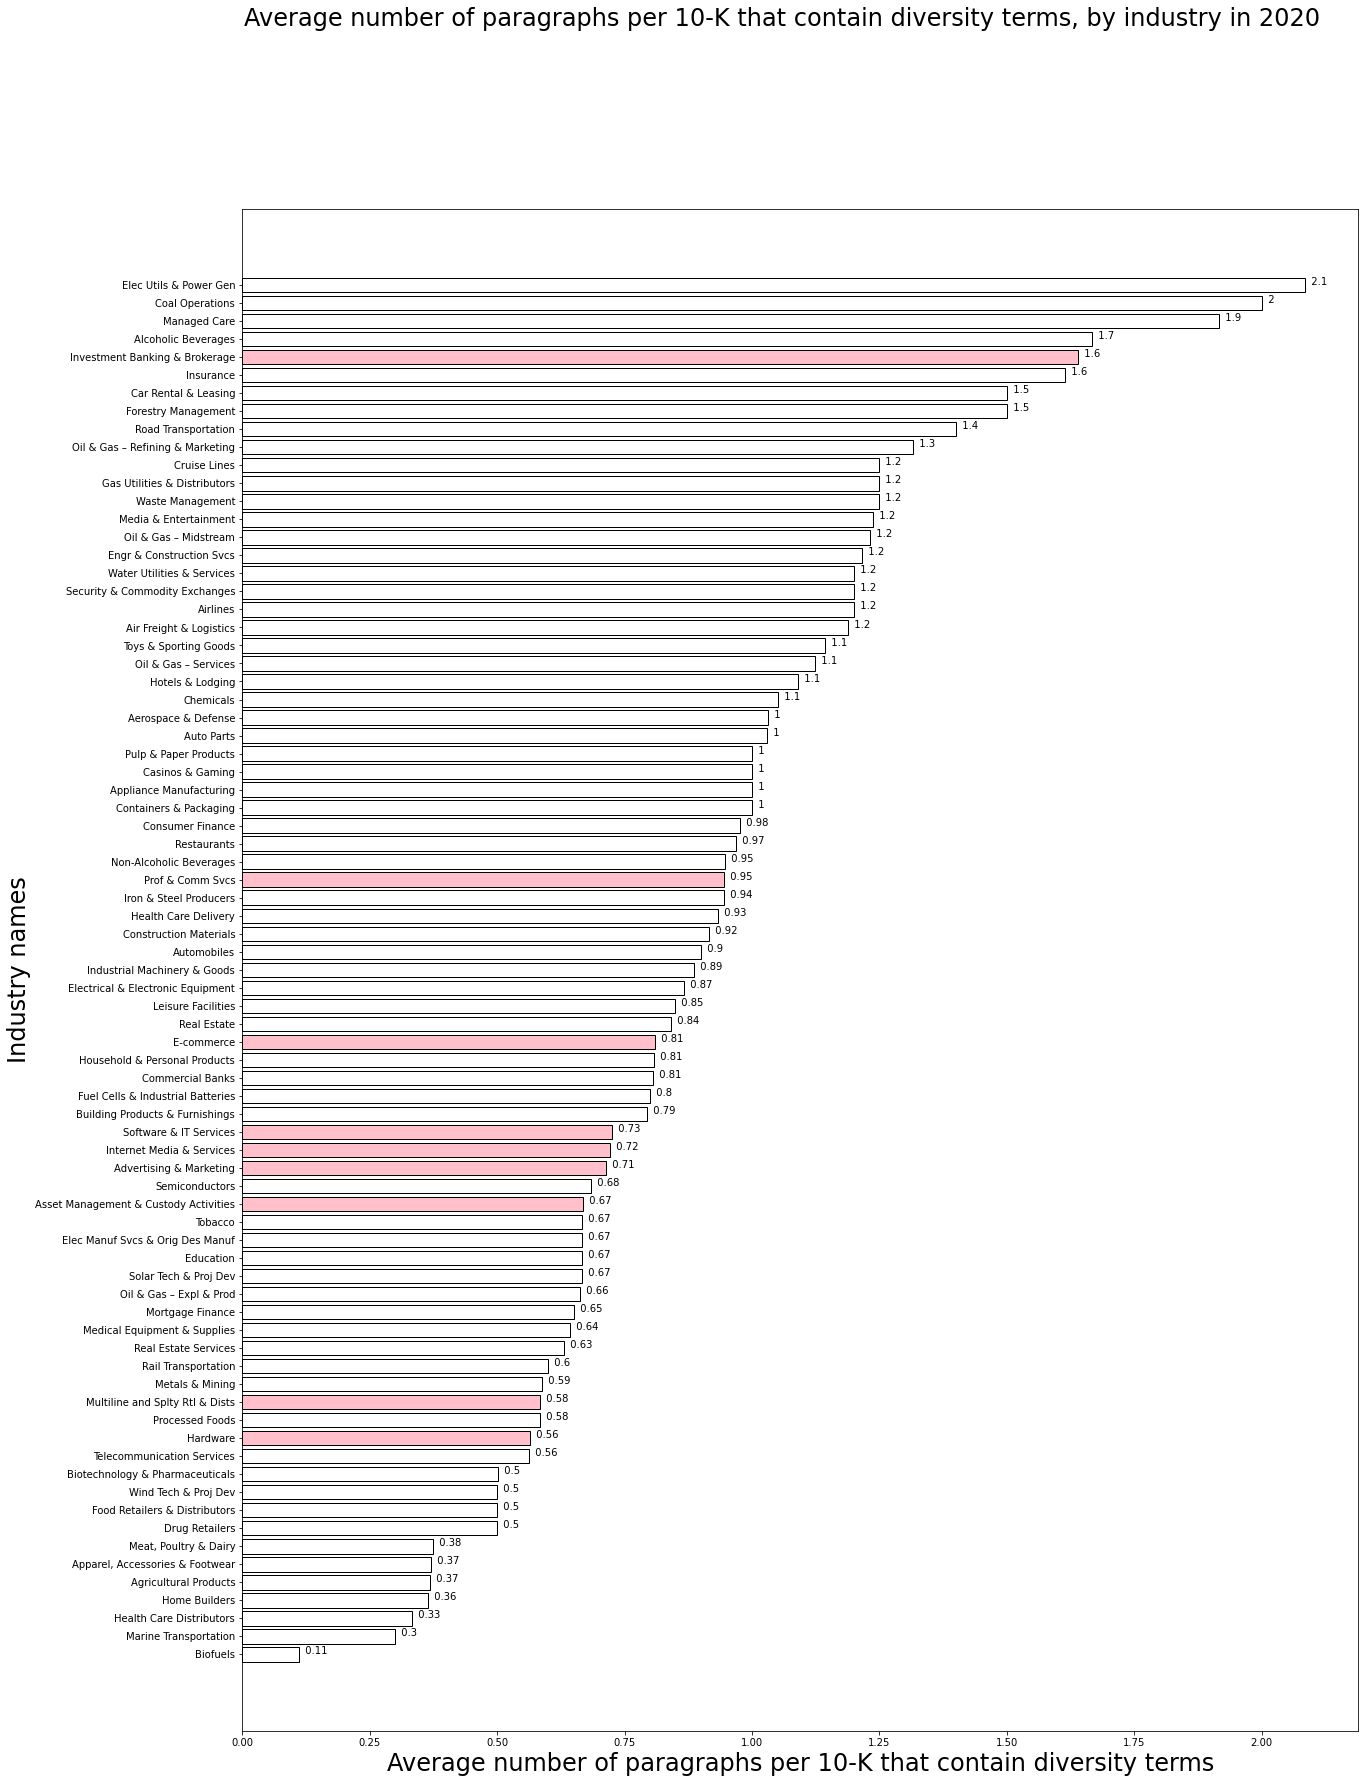

None
with industries with 0 terms


<Figure size 432x288 with 0 Axes>

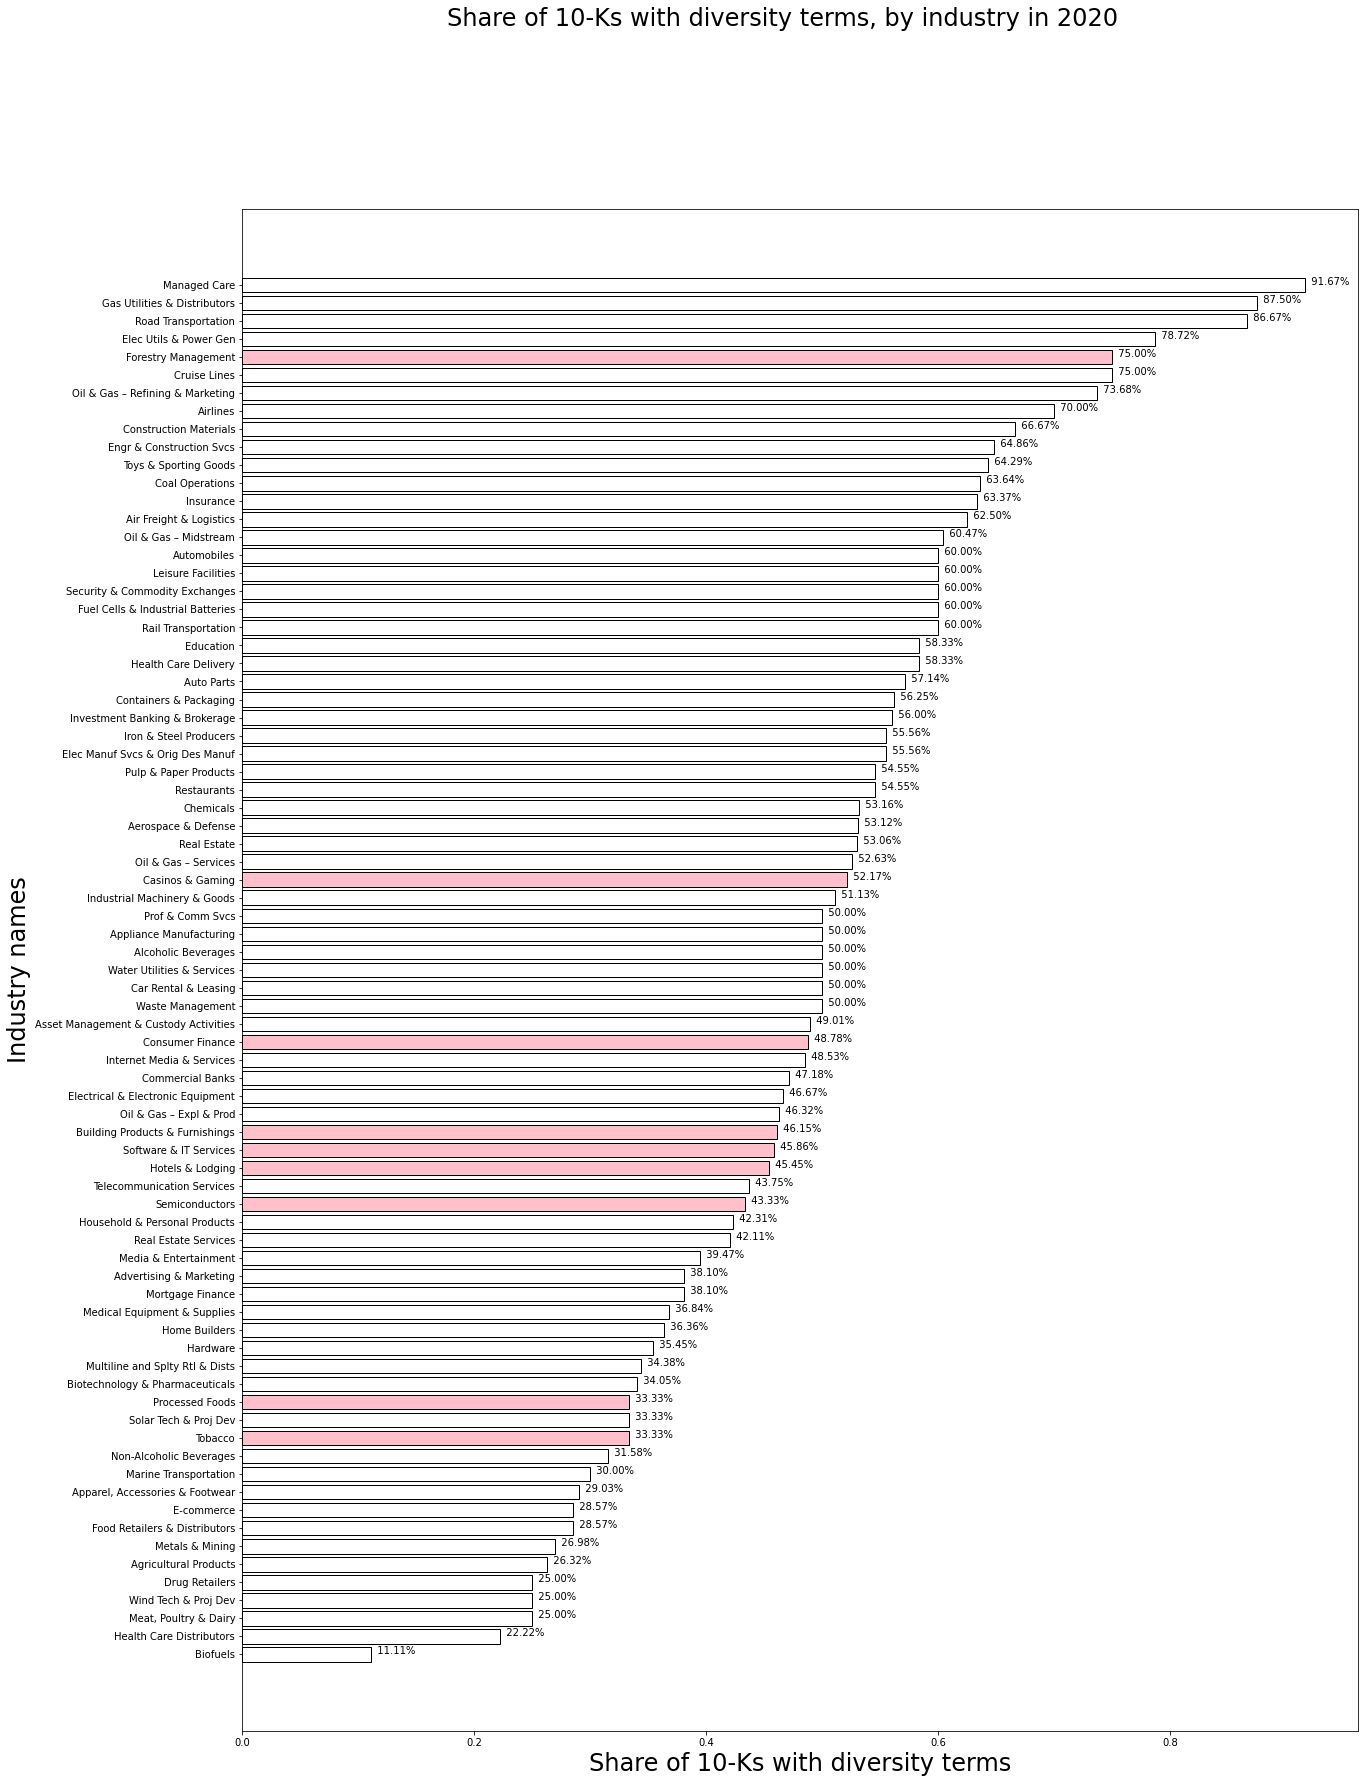

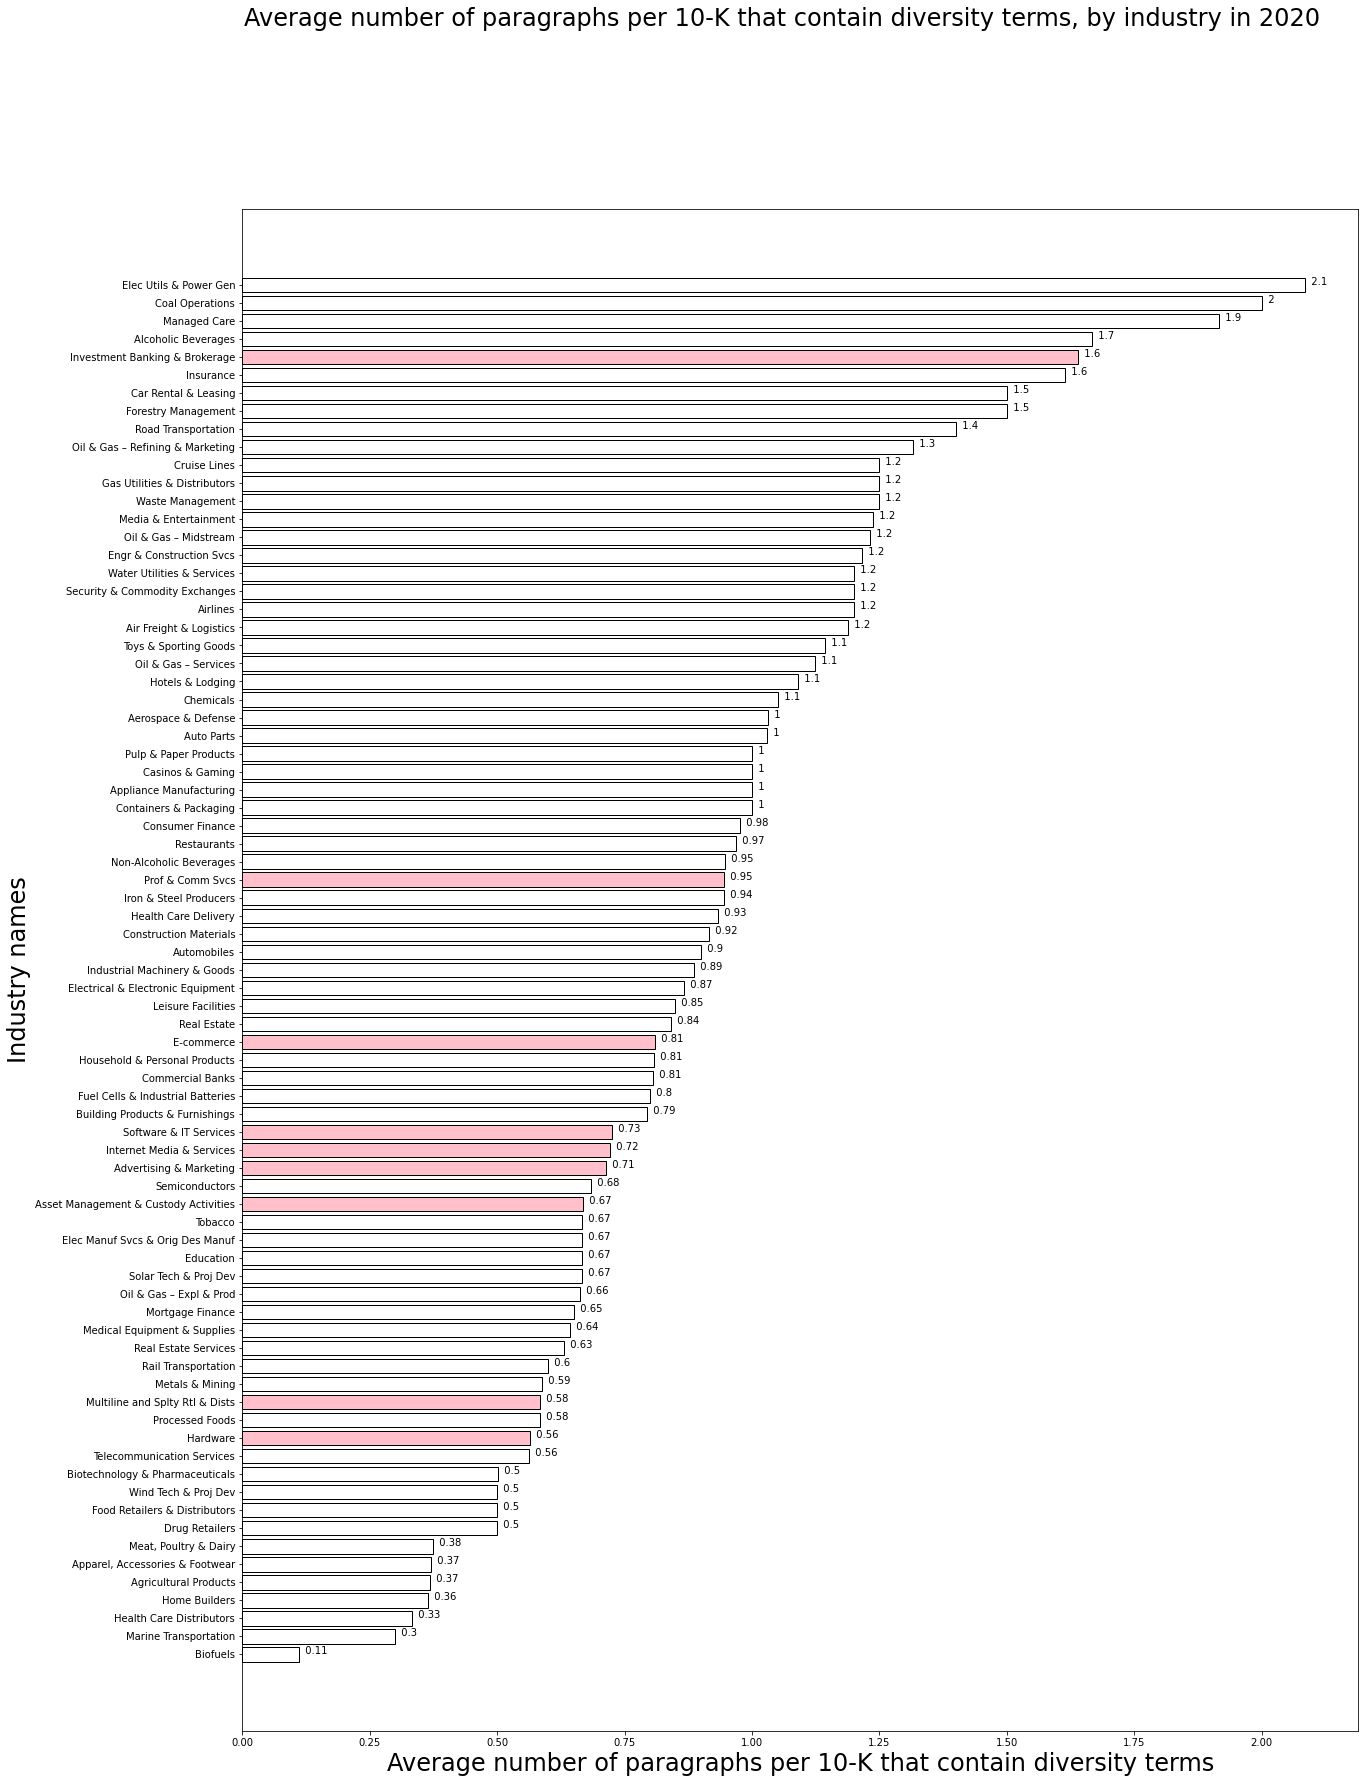

None


<Figure size 432x288 with 0 Axes>

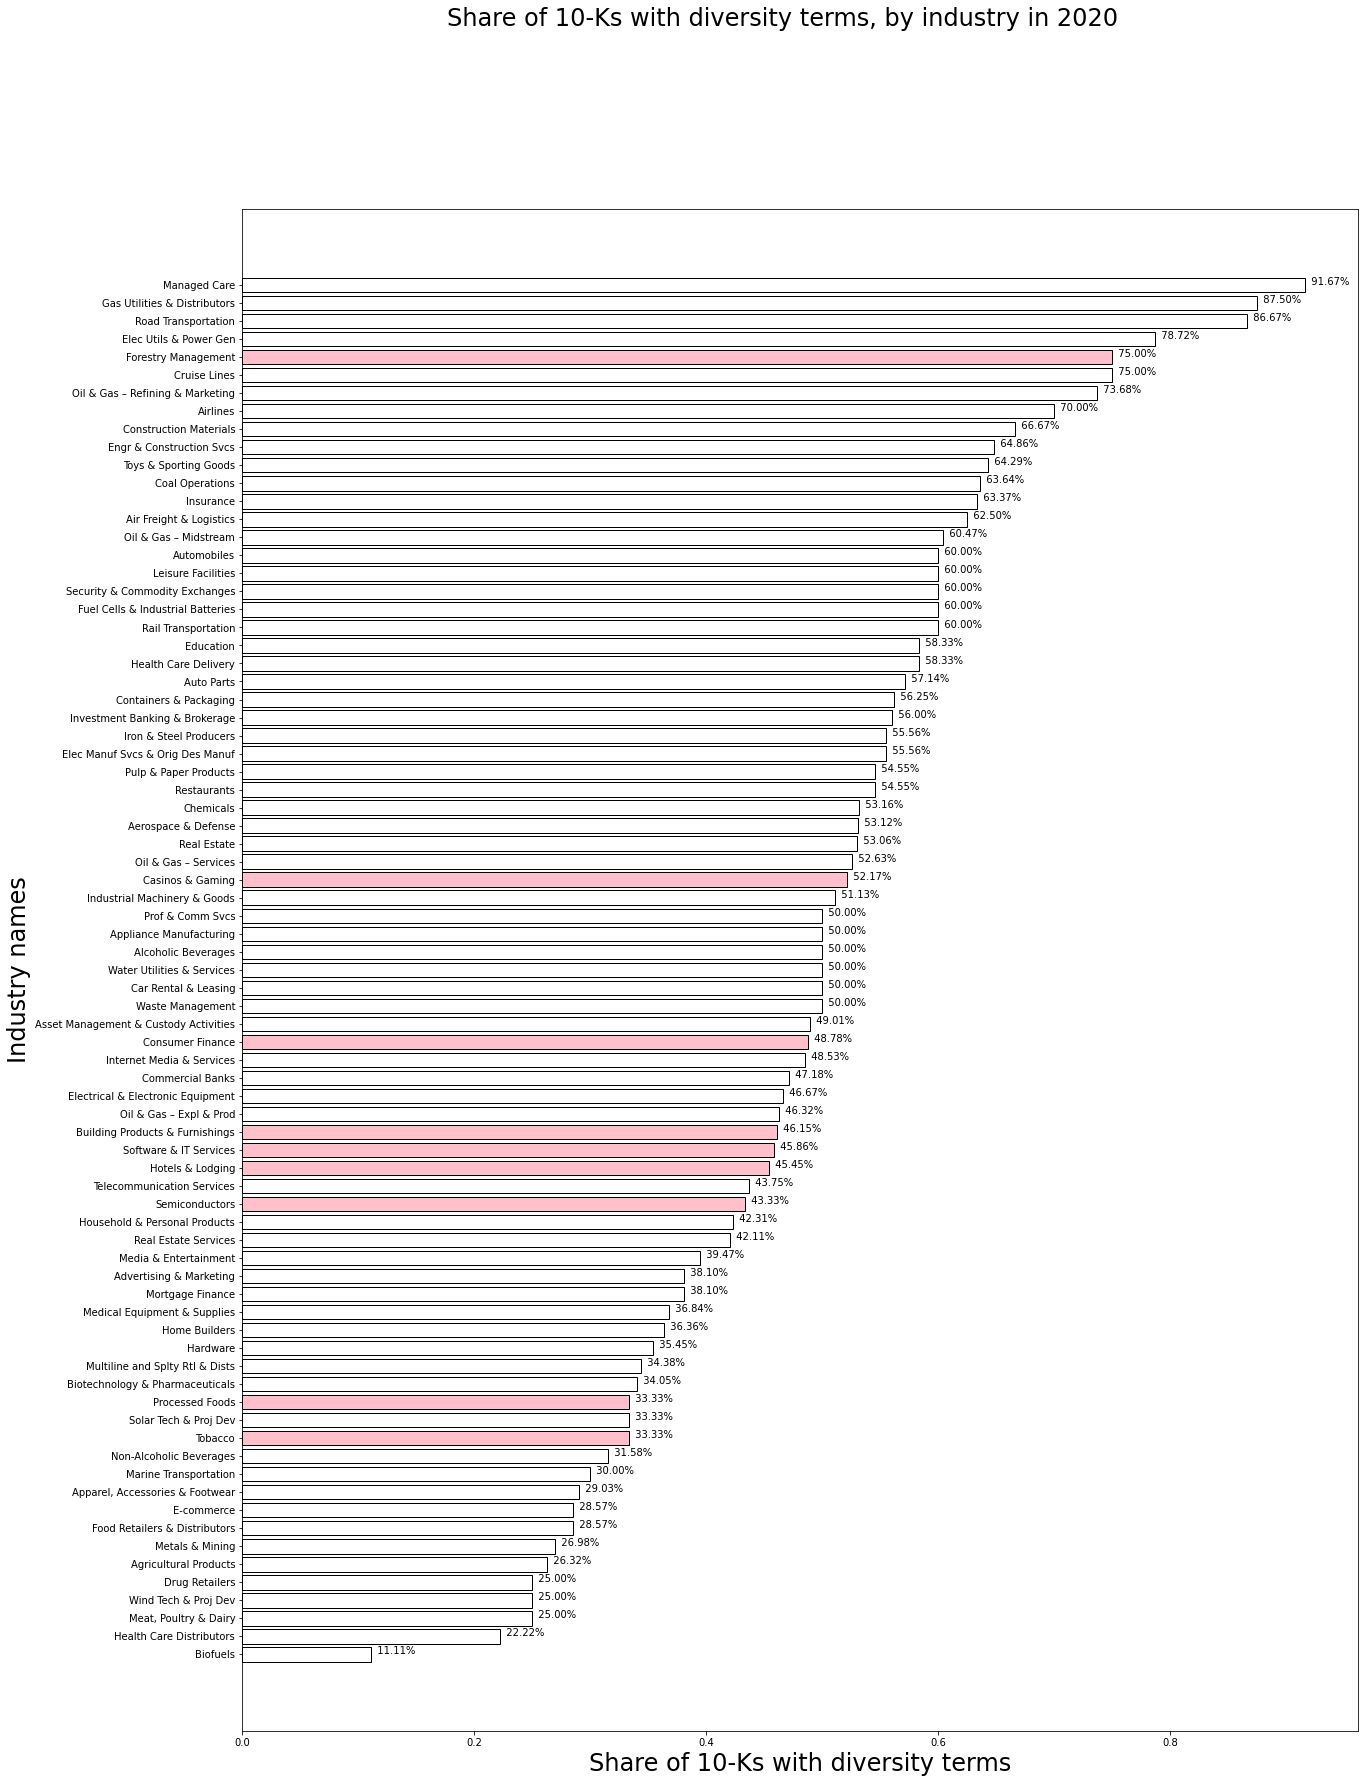

In [41]:
def clean_bar(df):
	df = df.rename(columns = {'primary_industry_desc':'Industry name', 
	                     'is_benchmark':'In Benchmark?','avg_pos':'Average paras per 10-K', 
											           'ubiq':'Share of 10-Ks'})
	sub = df[df['year'] == 2020][["Industry name","In Benchmark?","Average paras per 10-K", 'Share of 10-Ks']].sort_values(by = ["Average paras per 10-K"])
	# sub = tab_C_dict["2020"][["Industry name","In Benchmark?","Average paras per 10k"]] #.sort_values(by = ["Average paras per 10k"])
	plt.figure(figsize=(20,28))

	clrs = []
	for x,y in zip(sub["Industry name"], sub["In Benchmark?"]):
		if y == 'Yes':
			if x=='Benchmark':
				clrs.append('red')
		
			else:
				clrs.append('pink')
		else:
			clrs.append('white')

	# intensity bar chart
	sub_0 = sub
	sub = sub[["Industry name","In Benchmark?","Average paras per 10-K"]].sort_values(by = ["Average paras per 10-K"])		
	
	plt.barh(sub["Industry name"],sub["Average paras per 10-K"], color=clrs, edgecolor='black')

	for index, value in enumerate(sub["Average paras per 10-K"]):
			plt.text(value, index, '  '+str(format(value, ".2g")))

	plt.suptitle('Average number of paragraphs per 10-K that contain diversity terms, by industry in 2020', fontsize=24)
	plt.xlabel('Average number of paragraphs per 10-K that contain diversity terms', fontsize=24)
	plt.ylabel('Industry names', fontsize=24)
 
	plt.savefig('/content/gdrive/MyDrive/DFG Cost of Human Rights Violations/Notebooks to share/10Ks_Diversity/bar_ints_' + '''df''' + '_2020.png')
	plt.show()
	plt.clf()
	sub = sub_0[["Industry name","In Benchmark?","Share of 10-Ks"]].sort_values(by = ["Share of 10-Ks"])
 
 # ubiquity bar chart
	plt.figure(figsize=(20,28))
	plt.barh(sub["Industry name"],sub["Share of 10-Ks"], color=clrs, edgecolor='black')

	for index, value in enumerate(sub["Share of 10-Ks"]):
			plt.text(value, index, '  '+str(format(value, ".2%")))

	plt.suptitle('Share of 10-Ks with diversity terms, by industry in 2020', fontsize=24)
	plt.xlabel('Share of 10-Ks with diversity terms', fontsize=24)
	plt.ylabel('Industry names', fontsize=24)
	plt.savefig('/content/gdrive/MyDrive/DFG Cost of Human Rights Violations/Notebooks to share/10Ks_Diversity/bar_ubiq_' + '''df''' + '_2020.png')
	plt.show()
	plt.clf()
 

print("without industries with 0 terms")
print(clean_bar(int_no02))

print("with industries with 0 terms")
print(clean_bar(int_w02))


In [ ]:
import matplotlib.pyplot as plt


sub = tab_C_dict["2020"][["Industry name","In Benchmark?","Average paras per 10k"]].sort_values(by = ["Average paras per 10k"])
# sub = tab_C_dict["2020"][["Industry name","In Benchmark?","Average paras per 10k"]] #.sort_values(by = ["Average paras per 10k"])
plt.figure(figsize=(20,28))

clrs = []
for x,y in zip(sub["Industry name"], sub["In Benchmark?"]):
	if y == 'Yes':
		if x=='Benchmark Industries':
			clrs.append('red')
   
		else:
			clrs.append('pink')
	else:
		clrs.append('white')
    
plt.barh(sub["Industry name"],sub["Average paras per 10k"], color=clrs, edgecolor='black')

for index, value in enumerate(sub["Average paras per 10k"]):
    plt.text(value, index, '  '+str(value))

plt.suptitle('Average number of paragraphs per 10-K that contain diversity terms, by industry in 2020', fontsize=24)
plt.xlabel('Average number of paragraphs per 10-K that contain diversity terms', fontsize=24)
plt.ylabel('Industry names', fontsize=24)
plt.savefig('/content/gdrive/MyDrive/DFG Cost of Human Rights Violations/Notebooks to share/10Ks_Diversity/diversity_paras_2020.png')


In [ ]:
# Ubiquity measure

# **TABLE C**

In [ ]:
temp_C = df_result
temp_C = pd.merge(left=temp_C, right=df_ind_desc, on='primary_industry_id')
bm_inds = ['CG-EC','CG-MR','FN-AC','FN-IB','SV-AD','SV-PS','TC-HW','TC-IM','TC-SI']
temp_C = temp_C[["year", "primary_industry_id","primary_industry_desc", "doc_id", "p_id", "text"]]
temp_C = temp_C.drop_duplicates(["year", "doc_id","text"])

In [ ]:
temp_C[(temp_C["year"]=="2020")]

In [ ]:
trial_C1 = temp_C[["year", "primary_industry_id","primary_industry_desc", "p_id"]]
trial_C2 = temp_C[["year", "primary_industry_id","primary_industry_desc", "doc_id"]]
trial_C2 = trial_C2.drop_duplicates()

trial_C1 = trial_C1.groupby(["year","primary_industry_id","primary_industry_desc"])['p_id'].size().reset_index(name='count')
trial_C1 = trial_C1.rename(columns={"year" : "Year", "primary_industry_desc" : "Primary Industry", "count":"Total paras that mention diversity"})
trial_C2 = trial_C2.groupby(["year","primary_industry_id","primary_industry_desc"])['doc_id'].size().reset_index(name='count')
trial_C2 = trial_C2.rename(columns={"year" : "Year", "primary_industry_desc" : "Primary Industry", "count":"Total 10ks that mention diversity"})

In [ ]:
all_years_table_C = pd.merge(trial_C2, trial_C1,  how='left', left_on=['Year','primary_industry_id','Primary Industry'], right_on = ['Year','primary_industry_id','Primary Industry'])


In [ ]:
df_zero_industries = pd.DataFrame(columns=all_years_table_C.columns)

for i in range(2013,2021,1):
  cond = (all_years_table_C['Year']==str(i))
  inds = all_years_table_C[cond].primary_industry_id
  list_inds = set(df_ind_desc["primary_industry_id"]) - set(inds)
  list_inds = list(list_inds)
  # print("list_inds ", list_inds)

  for ind in list_inds:
    year, primary_industry_id, primary_industry_desc = str(i), ind, df_ind_desc.loc[df_ind_desc['primary_industry_id'] == ind, 'primary_industry_desc'].iloc[0]
    df_x = pd.DataFrame([[year, primary_industry_desc, 1, 0]], columns=['Year', 'Primary Industry','Total 10ks that mention diversity','Total paras that mention diversity'])
    df_zero_industries = df_zero_industries.append(df_x)


In [ ]:
all_years_table_C = pd.concat([all_years_table_C,df_zero_industries], axis=0)
all_years_table_C['In Benchmark?'] = all_years_table_C['primary_industry_id']\
  .apply(lambda x: 'Yes' if x in bm_inds else 'No')
all_years_table_C = all_years_table_C[['Year','primary_industry_id','Primary Industry', 'In Benchmark?', 'Total 10ks that mention diversity', 'Total paras that mention diversity']]

In [ ]:
# convert object to str
all_years_table_C["Primary Industry"] = all_years_table_C["Primary Industry"].astype(str)

In [ ]:
all_years_table_C = all_years_table_C.drop(columns=['primary_industry_id'])

In [ ]:
#@title table C splitting and BM
tab_C_dict = {}

for y in range(2013,2021):
  tab_C = all_years_table_C[all_years_table_C["Year"]==str(y)]
  bm = tab_C.groupby(["In Benchmark?"]).sum().loc["Yes"]
  tab_C = tab_C.append(pd.Series([str(y), "Benchmark Industries", "Yes", bm[2], bm[3]], index=all_years_table_C.columns[:5]), ignore_index=True)
  tab_C["Share"] = tab_C["Total paras that mention diversity"]/tab_C["Total 10ks that mention diversity"]  
  tab_C['Share'] = tab_C['Share'].apply(lambda x: round(x, 2))
  tab_C = tab_C.sort_values(["Share"], ascending=False)
  tab_C = tab_C.rename(columns={"Primary Industry":"Industry name", "Share" : "Average paras per 10k"})
  
  tab_C.index = np.arange(1, len(tab_C) + 1)
  tab_C_dict[str(y)] = tab_C
  tab_C.to_csv("/content/gdrive/MyDrive/DFG Cost of Human Rights Violations/Notebooks to share/10Ks_Diversity/tab_C_"+str(y)+ ".csv")


In [ ]:
import numpy as np


In [ ]:
table_C_all_years = pd.DataFrame()
for key in tab_C_dict:
  table_C_all_years = table_C_all_years.append(tab_C_dict[key])

table_C_all_years.to_csv("/content/gdrive/MyDrive/DFG Cost of Human Rights Violations/Notebooks to share/10Ks_Diversity/table_C_all_years.csv")

**Bar chart for 2020, for intensity of diversity mentions in industries**

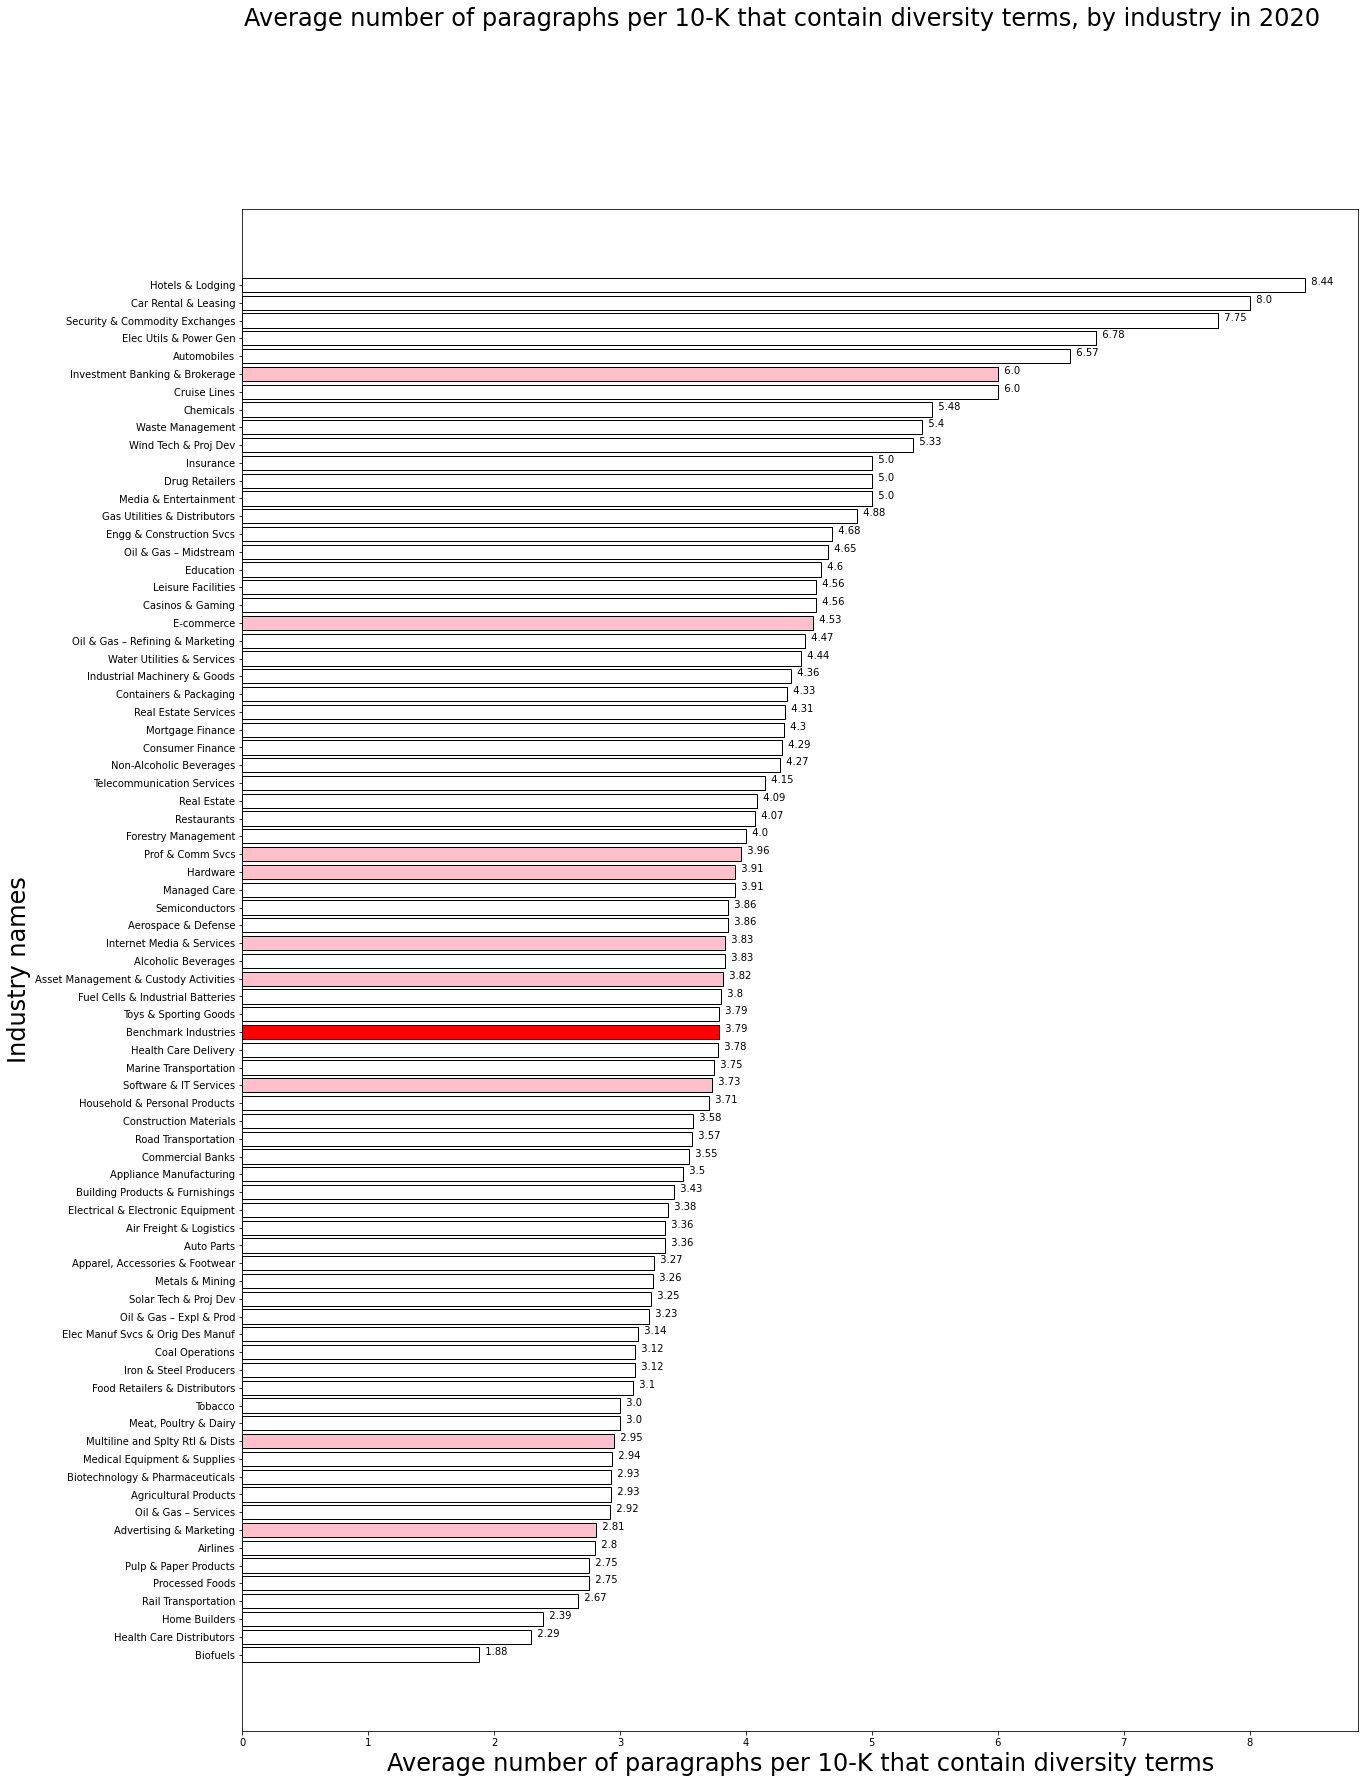

In [ ]:
import matplotlib.pyplot as plt
sub = tab_C_dict["2020"][["Industry name","In Benchmark?","Average paras per 10k"]].sort_values(by = ["Average paras per 10k"])
# sub = tab_C_dict["2020"][["Industry name","In Benchmark?","Average paras per 10k"]] #.sort_values(by = ["Average paras per 10k"])
plt.figure(figsize=(20,28))

clrs = []
for x,y in zip(sub["Industry name"], sub["In Benchmark?"]):
	if y == 'Yes':
		if x=='Benchmark Industries':
			clrs.append('red')
   
		else:
			clrs.append('pink')
	else:
		clrs.append('white')
    
plt.barh(sub["Industry name"],sub["Average paras per 10k"], color=clrs, edgecolor='black')

for index, value in enumerate(sub["Average paras per 10k"]):
    plt.text(value, index, '  '+str(value))

plt.suptitle('Average number of paragraphs per 10-K that contain diversity terms, by industry in 2020', fontsize=24)
plt.xlabel('Average number of paragraphs per 10-K that contain diversity terms', fontsize=24)
plt.ylabel('Industry names', fontsize=24)
plt.savefig('/content/gdrive/MyDrive/DFG Cost of Human Rights Violations/Notebooks to share/10Ks_Diversity/diversity_paras_2020.png')


# **TABLE C MEDIAN STATISTIC**

In [ ]:
temp_C = df_result
temp_C = pd.merge(left=temp_C, right=df_ind_desc, on='primary_industry_id')
bm_inds = ['CG-EC','CG-MR','FN-AC','FN-IB','SV-AD','SV-PS','TC-HW','TC-IM','TC-SI']
temp_C = temp_C[["year", "primary_industry_id","primary_industry_desc", "doc_id", "p_id"]]

In [ ]:
trial_C1 = temp_C[["year", "primary_industry_id","primary_industry_desc", "doc_id","p_id"]]
trial_C1 = trial_C1.groupby(["year","primary_industry_id","primary_industry_desc", "doc_id"])['p_id'].size().reset_index(name='count')
trial_C1 = trial_C1.rename(columns={"year" : "Year", "primary_industry_desc" : "Primary Industry", "count":"Total paras that mention diversity"})


In [ ]:
# drop doc_id from trial_C1
trial_C1 = trial_C1.drop(columns=["doc_id"])

In [ ]:
trial_C1["Primary Industry"] = trial_C1["Primary Industry"].astype(str)
trial_C1["Year"] = trial_C1["Year"].astype(str)

In [ ]:
trial_C1 = trial_C1.groupby(["Year","primary_industry_id","Primary Industry"])['Total paras that mention diversity'].median().reset_index(name='median paras')

In [ ]:
trial_C2 = temp_C[["year", "primary_industry_id","primary_industry_desc", "doc_id"]]
trial_C2 = trial_C2.drop_duplicates()
trial_C2 = trial_C2.groupby(["year","primary_industry_id","primary_industry_desc"])['doc_id'].size().reset_index(name='count')
trial_C2 = trial_C2.rename(columns={"year" : "Year", "primary_industry_desc" : "Primary Industry", "count":"Total 10ks that mention diversity"})

In [ ]:
all_years_table_C = pd.merge(trial_C2, trial_C1,  how='left', left_on=['Year','primary_industry_id','Primary Industry'], right_on = ['Year','primary_industry_id','Primary Industry'])

In [ ]:
df_zero_industries = pd.DataFrame(columns=all_years_table_C.columns)

for i in range(2013,2021,1):
  cond = (all_years_table_C['Year']==str(i))
  inds = all_years_table_C[cond].primary_industry_id
  list_inds = set(df_ind_desc["primary_industry_id"]) - set(inds)
  list_inds = list(list_inds)
  # print("list_inds ", list_inds)

  for ind in list_inds:
    year, primary_industry_id, primary_industry_desc = str(i), ind, df_ind_desc.loc[df_ind_desc['primary_industry_id'] == ind, 'primary_industry_desc'].iloc[0]
    df_x = pd.DataFrame([[year, primary_industry_desc, 1, 0]], columns=['Year', 'Primary Industry','Total 10ks that mention diversity','median paras'])
    df_zero_industries = df_zero_industries.append(df_x)

# all_years_table_C = pd.concat([all_years_table_C,df_zero_industries], axis=0)

In [ ]:
all_years_table_C = pd.concat([all_years_table_C,df_zero_industries], axis=0)
all_years_table_C['In Benchmark?'] = all_years_table_C['primary_industry_id']\
  .apply(lambda x: 'Yes' if x in bm_inds else 'No')
all_years_table_C = all_years_table_C[['Year','primary_industry_id','Primary Industry', 'In Benchmark?', 'Total 10ks that mention diversity', 'median paras']]

In [ ]:
all_years_table_C["Primary Industry"] = all_years_table_C["Primary Industry"].astype(str)

In [ ]:
all_years_table_C = all_years_table_C.drop(columns=['primary_industry_id'])

In [ ]:
tab_C_dict = {}

for y in range(2013,2021):
  tab_C = all_years_table_C[all_years_table_C["Year"]==str(y)]
  bm = tab_C.groupby(["In Benchmark?"]).sum().loc["Yes"]
  # print(bm)
  tab_C = tab_C.append(pd.Series([str(y), "Benchmark Industries", "Yes", bm[2], bm[3]/len(bm_inds)], index=all_years_table_C.columns[:5]), ignore_index=True)
  # tab_C["Share"] = tab_C["Total paras that mention diversity"]/tab_C["Total 10ks that mention diversity"]  
  tab_C['median paras'] = tab_C['median paras'].apply(lambda x: round(x, 1))
  tab_C = tab_C.sort_values(["median paras"], ascending=False)
  tab_C = tab_C.rename(columns={"Primary Industry":"Industry name", "median paras" : "Median paras per 10k"})
  
  tab_C.index = np.arange(1, len(tab_C) + 1)
  tab_C_dict[str(y)] = tab_C
  tab_C.to_csv("/content/gdrive/MyDrive/DFG Cost of Human Rights Violations/Notebooks to share/10Ks_Diversity/tab_C_"+str(y)+ ".csv", float_format='%.1f')

In [ ]:
table_C_all_years = pd.DataFrame()
for key in tab_C_dict:
  table_C_all_years = table_C_all_years.append(tab_C_dict[key])

# table_C_all_years.to_csv("table_C_all_years.csv", float_format='%.1f%%')
table_C_all_years.to_csv("/content/gdrive/MyDrive/DFG Cost of Human Rights Violations/Notebooks to share/10Ks_Diversity/table_C_all_years.csv") #, float_format='%.1f%%')

In [ ]:
tab_C_dict["2020"].columns

Index(['Year', 'Industry name', 'In Benchmark?',
       'Total 10ks that mention diversity', 'Median paras per 10k'],
      dtype='object')

In [ ]:
sub = tab_C_dict["2020"][["Industry name","In Benchmark?","Median paras per 10k"]].sort_values(by = ["Median paras per 10k"])
plt.figure(figsize=(20,28))

clrs = []
for x,y in zip(sub["Industry name"], sub["In Benchmark?"]):
	if y == 'Yes':
		if x=='Benchmark Industries':
			clrs.append('red')
   
		else:
			clrs.append('pink')
	else:
		clrs.append('white')  
plt.barh(sub["Industry name"],sub["Median paras per 10k"], color=clrs, edgecolor='black')
for index, value in enumerate(sub["Median paras per 10k"]):
    plt.text(value, index, '  '+str(value))

plt.suptitle('Median number of paragraphs per 10-K that mention diversity, by industry in 2020', fontsize=24)
plt.xlabel('Median number of paragraphs per 10-K that mention diversity', fontsize=24)
plt.ylabel('Industry names', fontsize=24)
plt.savefig('/content/gdrive/MyDrive/DFG Cost of Human Rights Violations/Notebooks to share/10Ks_Diversity/diversity_paras_median_2020.png')

**Intensity table ends here, following is the ubiquity measure**

In [ ]:
df_result = pd.merge(left=df_result, right=df_ind_desc, on='primary_industry_id')

In [ ]:
# load usable 10k info
df_10ks_sics = pd.read_csv('/content/gdrive/MyDrive/DFG Cost of Human Rights Violations/Datasets/10k_clean_text/_0.0 downloaded/usable_10ks_with_sics.csv')
df_10ks_sics['year'] = df_10ks_sics['fy'].astype('str').str[:4]

# calculate and join industry-level ticker counts
df_ind_total = df_10ks_sics.groupby(['year', 'primary_industry_id'])\
                .agg({'ticker_display': pd.Series.nunique}).reset_index()
df_ind_total.columns = ['year', 'primary_industry_id', 'ind_tot_tkr']

In [ ]:
df_result = pd.merge(left=df_result, right=df_ind_total, on=['year', 'primary_industry_id'])

In [ ]:
# calculate and join sector-level ticker counts

# get sector
sec_map = { 'CG': 'Consumer Goods',
            'EM': 'Extractives & Minerals Processing',
            'FB': 'Food & Beverage',
            'FN': 'Financials',
            'HC': 'Health Care',
            'IF': 'Infrastructure',
            'RR': 'Renewable Resources & Alternative Energy',
            'RT': 'Resource Transformation',
            'SV': 'Services',
            'TC': 'Technology & Communications',
            'TR': 'Transportation'
}
df_result['sector_id'] = df_result['primary_industry_id'].str[:2]
df_result['sector_desc'] = df_result['sector_id'].apply(lambda x: sec_map[x])

df_result['result'] = 1

# reivew data
df_result.head(3)

In [ ]:
bm_inds = ['CG-EC','CG-MR','FN-AC','FN-IB','SV-AD','SV-PS','TC-HW','TC-IM','TC-SI']
# make a copy of the result df
df_ht = df_result.copy()

### COMPANY LEVEL ###
# aggregate metrics from the paragraph level to the company level
df_ht = df_ht.groupby(['year', 'ticker_display', 
                       'sector_id', 'sector_desc', 
                       'primary_industry_id', 'primary_industry_desc', 
                       'tkr_tot_para', 'ind_tot_tkr',
                      #  'sec_tot_tkr'
                       ])\
                        .agg({'result': 'sum'})\
                        .reset_index()\
                        .sort_values(by=['year', 'primary_industry_id', 'ticker_display'])

df_ht = df_ht.rename(columns={'result': 'tkr_num_para'})

# compute % of paragraphs with mentions at the company level
df_ht['tkr_pct_para'] = df_ht['tkr_num_para']/df_ht['tkr_tot_para']

# include a count of 1 if there are more than 0 paragraphs for the company
df_ht['tkr_num_tkr'] = df_ht['tkr_num_para'].apply(lambda x: 1 if x > 0 else 0)

### INDUSTRY LEVEL ###
# aggregate metrics from the company level to the industry level

df_ht = df_ht.groupby(['year', 
                       'sector_id', 'sector_desc', 
                       'primary_industry_id', 'primary_industry_desc', 
                       'ind_tot_tkr'])\
                       .agg({'tkr_num_tkr': 'sum',
                             'tkr_pct_para': 'mean'})\
                       .reset_index()

df_ht = df_ht.rename(columns={'tkr_num_tkr': 'ind_num_tkr',
                              'tkr_pct_para': 'ind_pct_para'})

# compute the % of companies with mentions at the industry level
df_ht['ind_pct_tkr'] = df_ht['ind_num_tkr']/df_ht['ind_tot_tkr']

df_ht

### INDUSTRY LEVEL (NON-BENCHMARK) ###
# set up dataframe for non-benchmarked industries
# df_ht_nbm = df_ht[~df_ht['primary_industry_id'].isin(bm_inds)]
df_ht_nbm = df_ht
df_ht_nbm['bm_ind'] = df_ht_nbm['primary_industry_id']\
  .apply(lambda x: 'Yes' if x in bm_inds else 'No')

### INDUSTRY LEVEL (BENCHMARK) ###
# set up dataframe for benchmarked industries
df_ht_bm = df_ht[df_ht['primary_industry_id'].isin(bm_inds)]
df_ht_bm

# look for the overall % of companies with mentions among benchmarked industries
df_ht_bm = df_ht_bm.groupby(['year']).agg({'ind_pct_tkr': 'mean',
                                           'ind_pct_para': 'mean'})\
                                             .reset_index()
df_ht_bm = df_ht_bm.rename(columns={'ind_pct_tkr': 'bm_pct_tkr',
                                    'ind_pct_para': 'bm_pct_para'})

df_ht_bm

### INDUSTRY LEVEL - READY FOR HYPOTHESIS TESTING ###
# merge benchmark metric to non-benchmark metrics
df_ht = pd.merge(left=df_ht_nbm, right=df_ht_bm, on='year')

### This line is why we see only results from the sector CG
# df_ht[df_ht['primary_industry_id'].str.contains('CG')]

In [ ]:
import random
import plotly.express as px

# the following is used to randomly generate colors for each sector
list_of_colors = px.colors.qualitative.Bold
list_random = random.sample(range(len(list_of_colors)), len(df_ht['sector_id'].unique()))
sector_colors = [list_of_colors[i] for i in list_random]
sector_colors = dict(zip(df_ht['sector_id'].unique(),sector_colors))

In [ ]:
import pandas as pd
import chart_studio
import chart_studio.plotly as py
import chart_studio.tools as tls
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# TODO : change username and api_key
username = 'lawrence.c.lai'
api_key = 'MAgfxLXUwdlLHYetcYGd'
chart_studio.tools.set_credentials_file(username=username, api_key=api_key)

In [ ]:
df_ht_no_zeroes = df_ht

In [ ]:
df_zero_industries = pd.DataFrame(columns=df_ht.columns)

for i in range(2013,2021,1):
  cond = (df_ht['year']==str(i))
  inds = df_ht[cond].primary_industry_id
  list_inds = set(df_ind_desc["primary_industry_id"]) - set(inds)
  list_inds = list(list_inds)

  for ind in list_inds:
    # print("ind : ", ind)
    year, sector_id, primary_industry_id, primary_industry_desc = str(i), ind[:2], ind, df_ind_desc.loc[df_ind_desc['primary_industry_id'] == ind, 'primary_industry_desc'].iloc[0]
    df_x = pd.DataFrame([[year, sector_id, None, primary_industry_id, primary_industry_desc, 'No', 0, 1, 0, 0]], columns=['year', 'sector_id', 'sector_desc','primary_industry_id', 'primary_industry_desc','bm_ind','ind_num_tkr', 'ind_tot_tkr', 'ind_pct_tkr','bm_pct_tkr'])
    # print("primary_industry_desc : ", primary_industry_desc)
    df_zero_industries = df_zero_industries.append(df_x)


In [ ]:
df_zero_industries

In [ ]:
df_ht = pd.concat([df_ht,df_zero_industries], axis=0)

In [ ]:
df_ht.groupby(by=["year", "sector_id", "primary_industry_id"]).sum()

In [ ]:
df_ht_no_zeroes.columns

Index(['year', 'sector_id', 'sector_desc', 'primary_industry_id',
       'primary_industry_desc', 'ind_tot_tkr', 'ind_num_tkr', 'ind_pct_para',
       'ind_pct_tkr', 'bm_ind', 'bm_pct_tkr', 'bm_pct_para'],
      dtype='object')

**Table for Ubiquity (Table_A) measure starts here!**


In [ ]:
df_ht["ind_tot_tkr"] = df_ht["ind_tot_tkr"].astype(str).astype(int)
df_ht["ind_num_tkr"] = df_ht["ind_num_tkr"].astype(str).astype(int)

In [ ]:
# trial = df_ht_no_zeroes[["bm_ind", "year","primary_industry_desc", "ind_tot_tkr", "ind_num_tkr"]]
trial = df_ht[["bm_ind", "year","primary_industry_desc", "ind_tot_tkr", "ind_num_tkr"]]
trial = trial.rename(columns={"primary_industry_desc": "Industry_name", "ind_tot_tkr": "Total_#10Ks", "ind_num_tkr" : "#_Positive_10Ks", "bm_ind" : "In Benchmark?"})

table_A_dict = {}

In [ ]:
pd.options.display.float_format = '{:,.1f}%'.format

In [ ]:
for y in range(2013,2021):
  table_A = trial[trial["year"]==str(y)]
  bm = table_A.groupby(["In Benchmark?"]).sum().loc["Yes"]
  table_A = table_A.append(pd.Series(["Yes", str(y), "Benchmark Industries", bm[0], bm[1]], index=trial.columns[:5]), ignore_index=True)
  table_A["Share"] = 100*table_A['#_Positive_10Ks']/table_A['Total_#10Ks']
  table_A['Share'] = table_A['Share'].apply(np.int64)
  table_A = table_A.sort_values(["Share"], ascending=False)
  table_A.index = np.arange(1, len(table_A) + 1)
  table_A = table_A[["year", "Industry_name", "In Benchmark?", "Total_#10Ks", "#_Positive_10Ks", "Share"]]
  table_A = table_A.rename(columns={"year" : "Year","Industry_name" : "Industry name", "Total_#10Ks": "Total no. of 10Ks", "#_Positive_10Ks": "10Ks that mention diversity", "Share" : "Share of 10Ks"})
  table_A_dict[str(y)] = table_A
  table_A.to_csv("table_A_"+str(y)+ ".csv", float_format='%.1f%%')


In [ ]:
table_A_all_years = pd.DataFrame()
for key in table_A_dict:
  # print("key : ", key)
  table_A_all_years = table_A_all_years.append(table_A_dict[key])

table_A_all_years.to_csv("/content/gdrive/MyDrive/DFG Cost of Human Rights Violations/Notebooks to share/10Ks_Diversity/table_A_all_years.csv", float_format='%.1f%%')

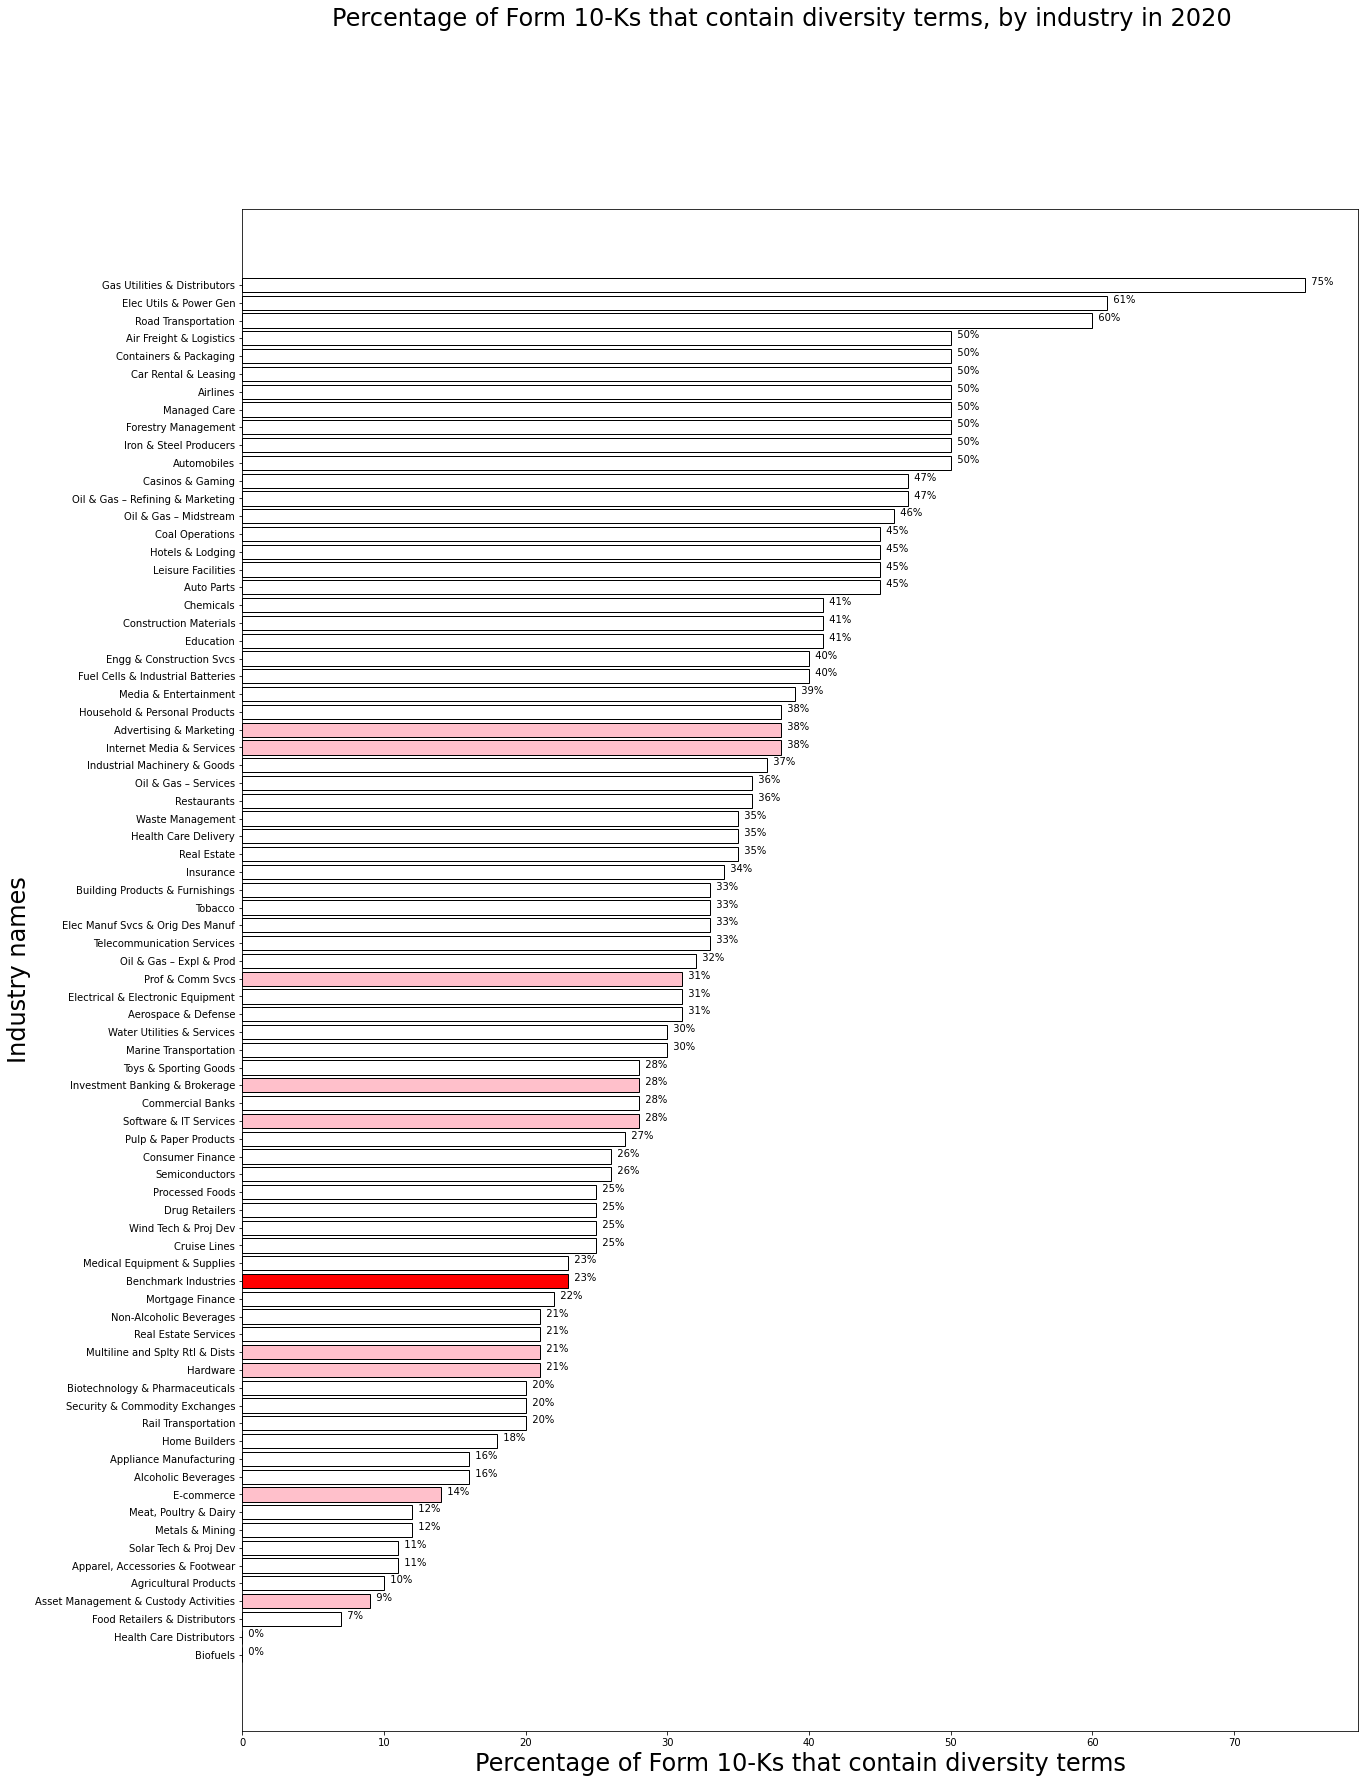

In [ ]:
sub = table_A_dict["2020"][["Industry name","In Benchmark?","Share of 10Ks"]].sort_values(by = ["Share of 10Ks"])
plt.figure(figsize=(20,28))

clrs = []
for x,y in zip(sub["Industry name"], sub["In Benchmark?"]):
	if y == 'Yes':
		if x=='Benchmark Industries':
			clrs.append('red')
   
		else:
			clrs.append('pink')
	else:
		clrs.append('white')  
plt.barh(sub["Industry name"],sub["Share of 10Ks"], color=clrs, edgecolor='black')
for index, value in enumerate(sub["Share of 10Ks"]):
    plt.text(value, index, '  '+str(value)+'%')

plt.suptitle('Percentage of Form 10-Ks that contain diversity terms, by industry in 2020', fontsize=24)
plt.xlabel('Percentage of Form 10-Ks that contain diversity terms', fontsize=24)
plt.ylabel('Industry names', fontsize=24)
plt.savefig('/content/gdrive/MyDrive/DFG Cost of Human Rights Violations/Notebooks to share/10Ks_Diversity/diversity_2020.png')


In [ ]:
# import package
import plotly.graph_objects as go

sector_colors = {'CG': {'fill': 'rgb(127, 60, 141)', 'line': 'rgb(99, 46, 110)'},
                'EM': {'fill': 'rgb(128, 186, 90)', 'line': 'rgb(105, 153, 73)'},
                'FB': {'fill': 'rgb(0, 134, 149)', 'line': 'rgb(1, 110, 122)'},
                'FN': {'fill': 'rgb(207, 28, 144)', 'line': 'rgb(163, 21, 114)'},
                'HC': {'fill': 'rgb(17, 165, 121)', 'line': 'rgb(12, 117, 86)'},
                'IF': {'fill': 'rgb(231, 63, 116)', 'line': 'rgb(184, 48, 91)'},
                'RR': {'fill': 'rgb(230, 131, 16)', 'line': 'rgb(181, 102, 11)'},
                'RT': {'fill': 'rgb(57, 105, 172)', 'line': 'rgb(41, 76, 125)'},
                'SV': {'fill': 'rgb(249, 123, 114)', 'line': 'rgb(199, 97, 90)'},
                'TC': {'fill': 'rgb(242, 183, 1)', 'line': 'rgb(199, 149, 0)'},
                'TR': {'fill': 'rgb(165, 170, 153)', 'line': 'rgb(121, 125, 111)'}
                 }

# set up figure
fig = go.Figure()

# for each sector, add a box trace
for sector_id in df_ht['sector_id'].unique():

    df_tmp = df_ht[(df_ht['sector_id'] == sector_id)]
    df_tmp = df_tmp[~(df_tmp['primary_industry_id'].isin(bm_inds))]

    sector_desc = df_tmp['sector_desc'].unique()[0]

    df_text = df_tmp[['year', 'sector_id', 'sector_desc',
                      'primary_industry_id', 'primary_industry_desc',
                      'bm_ind', 
                      'ind_num_tkr', 'ind_tot_tkr', 'ind_pct_tkr',
                      'bm_pct_tkr']]

    trace = go.Box(y = df_tmp['ind_pct_tkr'],   # plotting the percentage of industries that have the the terms we are interested in, in that para.
                  x = df_tmp['year'], 
                  name = sector_desc, 
                  text = df_text, 
                  marker = dict(color=sector_colors[sector_id]['fill'],
                                line=dict(width=1, 
                                          color=sector_colors[sector_id]['line'])),
                  line = dict(color = 'rgba(0,0,0,0)'),
                  fillcolor = 'rgba(0,0,0,0)',
                  hoveron='points'
                  )
    fig.add_trace(trace)

# for benchmark, add a box trace
df_tmp = df_ht[['year', 'bm_pct_tkr']].drop_duplicates()

trace = go.Box(x=df_tmp['year'], 
               y=df_tmp['bm_pct_tkr'], 
               name='Benchmark',
               marker = dict(color= 'grey', opacity=0),
               line = dict(color = 'lightseagreen', width=3),
               hoverinfo = 'skip',
               hoveron='boxes'
               )
fig.add_trace(trace)

trace = go.Box(x=df_tmp['year'], 
               y=df_tmp['bm_pct_para'], 
               name='Benchmark',
               marker = dict(color= 'grey', opacity=0),
               line = dict(color = 'lightseagreen', width=3),
               hoverinfo = 'skip',
               hoveron='boxes'
               )
fig.add_trace(trace)

# update traces
fig.update_traces(hovertemplate ='Year: %{text[0]}<br>'+
                                #  'Sector ID: %{text[1]}<br>'+
                                 'Sector: %{text[2]}<br>'+
                                #  'Industry ID: %{text[3]}<br>'+
                                 'Industry: %{text[4]}<br>'+
                                 'Benchmark?: %{text[5]}<br>'+
                                 '# of companies with mentions: %{text[6]}<br>'+
                                 'Total # of companies: %{text[7]}<br>'+
                                 'Industry %: %{text[8]:.2%}<br>'+
                                 'Benchmark %: %{text[9]:.2%}<br>',
                 boxpoints = 'all',
                 pointpos = 0,
                 jitter = 1,
                  )

# update layout
### UPDATE ME!!! ###

fig.update_layout(
    title='Proportion of Form 10-K filers with mentions of diversity terms <br>'+\
          '<br>Benchmarks: '+', '.join(bm_inds),
    xaxis_title='Fiscal year',
    yaxis_title='Proportion of companies with mentions',
    template = 'plotly',
    yaxis=dict(tickformat=".0%", range=[-0.01,1.1*df_ht['ind_pct_tkr'].max()]),
)

fig.show()
# upload to plotly
### UPDATE ME!!! ###  To link this in a different site, comment this out
py.plot(fig, filename = 'dfg-cohrv_pct-tkr_'+'-'.join(['430.1']), auto_open=False)

In [ ]:
# df_ht['ind_pct_tkr'].min()
df_ht.columns

Index(['year', 'sector_id', 'sector_desc', 'primary_industry_id',
       'primary_industry_desc', 'ind_tot_tkr', 'ind_num_tkr', 'ind_pct_para',
       'ind_pct_tkr', 'bm_ind', 'bm_pct_tkr', 'bm_pct_para'],
      dtype='object')

In [ ]:
# import package
import plotly.graph_objects as go

sector_colors = {'CG': {'fill': 'rgb(127, 60, 141)', 'line': 'rgb(99, 46, 110)'},
                'EM': {'fill': 'rgb(128, 186, 90)', 'line': 'rgb(105, 153, 73)'},
                'FB': {'fill': 'rgb(0, 134, 149)', 'line': 'rgb(1, 110, 122)'},
                'FN': {'fill': 'rgb(207, 28, 144)', 'line': 'rgb(163, 21, 114)'},
                'HC': {'fill': 'rgb(17, 165, 121)', 'line': 'rgb(12, 117, 86)'},
                'IF': {'fill': 'rgb(231, 63, 116)', 'line': 'rgb(184, 48, 91)'},
                'RR': {'fill': 'rgb(230, 131, 16)', 'line': 'rgb(181, 102, 11)'},
                'RT': {'fill': 'rgb(57, 105, 172)', 'line': 'rgb(41, 76, 125)'},
                'SV': {'fill': 'rgb(249, 123, 114)', 'line': 'rgb(199, 97, 90)'},
                'TC': {'fill': 'rgb(242, 183, 1)', 'line': 'rgb(199, 149, 0)'},
                'TR': {'fill': 'rgb(165, 170, 153)', 'line': 'rgb(121, 125, 111)'}
                 }

# set up figure
fig = go.Figure()

# for each sector, add a box trace
for sector_id in df_ht['sector_id'].unique():
  
    df_tmp = df_ht[(df_ht['sector_id'] == sector_id)]
    df_tmp = df_tmp[~(df_tmp['primary_industry_id'].isin(bm_inds))]

    sector_desc = df_tmp['sector_desc'].unique()[0]

    df_text = df_tmp[['year', 'sector_id', 'sector_desc',
                      'primary_industry_id', 'primary_industry_desc',
                      'bm_ind',
                      'ind_pct_para', 'bm_pct_para']]

    trace = go.Box(y = df_tmp['ind_pct_para'],  # Only different line -> IMP
                  x = df_tmp['year'], 
                  name = sector_desc, 
                  text = df_text, 
                  marker = dict(color=sector_colors[sector_id]['fill'],
                                line=dict(width=1, 
                                          color=sector_colors[sector_id]['line'])),
                  line = dict(color = 'rgba(0,0,0,0)'),
                  fillcolor = 'rgba(0,0,0,0)',
                  hoveron='points'
                  )
    fig.add_trace(trace)

# for benchmark, add a box trace
df_tmp = df_ht[['year', 'bm_pct_para']].drop_duplicates()

trace = go.Box(x=df_tmp['year'], 
               y=df_tmp['bm_pct_para'], 
               name='Benchmark',
               marker = dict(color= 'grey', opacity=0),
               line = dict(color = 'lightseagreen', width=3),
               hoverinfo = 'skip',
               hoveron='boxes'
               )
fig.add_trace(trace)

# update traces
fig.update_traces(hovertemplate ='Year: %{text[0]}<br>'+
                                #  'Sector ID: %{text[1]}<br>'+
                                 'Sector: %{text[2]}<br>'+
                                #  'Industry ID: %{text[3]}<br>'+
                                 'Industry: %{text[4]}<br>'+
                                 'Benchmark?: %{text[5]}<br>'+
                                 'Industry %: %{text[6]:.2%}<br>'+
                                 'Benchmark %: %{text[7]:.2%}<br>',
                 boxpoints = 'all',
                 pointpos = 0,
                 jitter = 1,
                  )

# update layout
### UPDATE ME!!! ###
fig.update_layout(
    title='Average proportion of Form 10-K paragraphs with mentions diversity <br>'+\
          '<br>Benchmarks: '+', '.join(bm_inds),
    xaxis_title='Fiscal year',
    yaxis_title='Average proportion of paragraphs with mentions',
    template = 'plotly',
    yaxis=dict(tickformat=".0%", range=[0, df_ht['ind_pct_para'].max()]),
)

# print(LIST_OF_HEURISTICS)
fig.show()

# upload to plotly
# ### UPDATE ME!!! ###
# py.plot(fig, filename = 'dfg-cohrv_avg-pct-para_'+'-'.join(['430.1']), auto_open=False)

In [ ]:
fig = go.Figure()

for year in df_ht['year'].unique():

  df_tmp = df_ht[df_ht['year'] == year]

  trace = go.Box(y = df_tmp['ind_pct_tkr'], 
                 x = df_tmp['year'], 
                #  name = sector_id, 
                 text = df_text,
                 showlegend=False,
                 line = dict(color = 'rgb(141,160,203)'),
                #  fillcolor = 'lightgray',
                 boxpoints = 'outliers',
                #  boxmean = 'sd',
                 )
  
  fig.add_trace(trace)

for sector in df_ht['sector_id'].unique():
  

  df_tmp = df_ht[df_ht['sector_id'] == sector]
  # df_tmp = df_tmp[~(df_tmp['primary_industry_id'].isin(bm_inds))]

  df_text = df_tmp[['year', 'primary_industry_id', 'primary_industry_desc', 
                    'ind_num_tkr', 'ind_tot_tkr', 'ind_pct_tkr']]

  trace = go.Box(y = df_tmp['ind_pct_tkr'], # IMP
                 x = df_tmp['year'], 
                 name = sector, 
                 text = df_text,
                 marker = dict(color=sector_colors[sector]['fill'],
                                line=dict(
                                          color=sector_colors[sector]['line'])),
                 showlegend=True,
                 line = dict(color = 'rgba(0,0,0,0)'),
                 fillcolor = 'rgba(0,0,0,0)',
                 hovertemplate ='Year: %{text[0]}<br>'+
                                 'Industry ID: %{text[1]}<br>'+
                                 'Industry: %{text[2]}<br>'+
                                 '# of companies with mentions: %{text[3]}<br>'+
                                 'Total # companies in industry: %{text[4]}<br>'+
                                 '% of companies with mentions: %{text[5]:.2%}<br>',
                 boxpoints = 'all',
                #  pointpos = -1,
                 jitter = 1
                 )
  
  fig.add_trace(trace)

# fig.update_traces()

fig.update_layout(
    title='GIC 430: Supply Chain Management<br>'+
          'Percentage of companies in an industry that mentioned the following in their supply chains <br>',\
    xaxis_title='Fiscal year',
    yaxis_title='Percentage of companies ',
    template = 'plotly',
    yaxis=dict(tickformat=".0%"),
    boxgap = 0.25,
    boxgroupgap = 0.5
)

fig.show()
# py.plot(fig, filename = 'dfg-cohrv-pct-tkr-box'+'-'.join(['430.1']), auto_open=False)

In [ ]:

df_result[(df_result['primary_industry_id']=='TC-ES')&(df_result['year']=='2017')].iloc[:,:7]

,gic_heuristic_id,id,ticker_display,primary_industry_id,text,yr_qtr,ticker


In [ ]:
df_result[(df_result['primary_industry_id']=='SV-HL')&(df_result['year']=='2020')].iloc[:,:7] # going through paras

,gic_heuristic_id,id,ticker_display,primary_industry_id,text,yr_qtr,ticker
39,330.2,2021Q1_HGV_10-K_20201231_0001564590-21-009825.txt_52,HGV,SV-HL,For more than 25 years we have created and delivered vacation experiences for guests from around the world. Our people first talent strategy is inclusive of programs and services which are designed to ensure that our employees feel engaged appreciated and rewarded for their contributions. We focus on hiring practices that are reflective of our values and seek customer-centric individuals that embody a spirit of service towards our owners guests and fellow team members. We believe hiring people with different backgrounds cultures and perspectives leads to increased creativity and innovation. We are committed to connecting with and engaging talent from diverse backgrounds to ensure our team member population is reflective of the communities in which we live and work. Using a multi-channel approach we grow our HGV talent network through a variety of outreach programs that include targeted media team member referrals and diversity outreach. As of December 31 2020 more than 6700 including furloughed team members were employed at our timeshare resorts call centers and corporate locations around the world.,2021Q1,HGV
40,330.2,2021Q1_HGV_10-K_20201231_0001564590-21-009825.txt_55,HGV,SV-HL,We are committed to an inclusive workforce that fully represents many different cultures backgrounds and viewpoints. Our Team Member Resource Groups (TMRGs) which are voluntary employee-led groups play an integral part in our culture of inclusion as we strive to foster openness integrity and respect. We currently have six TMRG's: African American Asia Pacific Islander Hispanic Latino LGBTQ & Friends Military and Women's. Each group is sponsored by a senior executive who provides leadership and helps drives initiatives across the business. In addition we believe that multiple perspectives generate better solutions and relatability with our diverse base of customers and consumers. We strike to ensure a common inclusion that we believe is reflected in our programs and initiatives and we regularly seek team member feedback through our annual engagement survey and ongoing discussions with our TMRG's.,2021Q1,HGV
41,330.2,2021Q1_HGV_10-K_20201231_0001564590-21-009825.txt_56,HGV,SV-HL,Through a variety of delivery methods we offer over 1000 training and development courses to all of our team members focused on variety of core competencies including: leadership diversity and inclusion skills training business acumen culture and personal growth. In 2020 team members completed approximately 65000 hours total training hours with over 8200 hours specifically dedicated to compliance training.,2021Q1,HGV
42,330.2,2021Q1_HLT_10-K_20201231_0001585689-21-000016.txt_63,HLT,SV-HL,"We are committed to an inclusive workforce that fully represents many different cultures backgrounds and viewpoints. Our President and Chief Executive Officer chairs the Hilton Executive Inclusion Council which comprises the Company's most senior leaders and provides oversight of our diversity and inclusion programs and initiatives. Additionally each of our eight Team Member Resource Groups (""TMRG"") is sponsored by an executive committee leader. These groups provide members with opportunities for career development and the chance to share their unique perspectives and viewpoints with leadership and other colleagues. We also leverage our TMRGs to provide insights for our business. With over 50 chapters across the world our TMRGs utilize virtual programming so that even during the pandemic we are continuing to stay connected and drive important conversations about inclusion and equity across the enterprise.",2021Q1,HLT
43,330.2,2021Q1_HLT_10-K_20201231_0001585689-21-000016.txt_64,HLT,SV-HL,We require all employees to complete training as part of our Inclusive and Respectful Workplace curriculum which is based on the underlying principles of our Code

In [ ]:
# THIS CODE CELL DOES NOT CONSIDER MEDIANS.
# AGGREGATION OF # OF TICKERS AND # OF PARAGRAPHS ARE DONE AT THE INDUSTRY
# AND BENCHMARK GROUP LEVELS.

# make a copy of the result df
df_ht = df_result.copy()

### COMPANY LEVEL ###
# aggregate metrics from the paragraph level to the company level
df_ht = df_ht.groupby(['gic_heuristic_id', 'year', 'ticker_display', 
                       'sector_id', 'sector_desc', 
                       'primary_industry_id', 'primary_industry_desc', 
                       'tkr_tot_para', 'ind_tot_tkr',
                      #  'sec_tot_tkr'
                       ])\
                        .agg({'result': 'sum'})\
                        .reset_index()\
                        .sort_values(by=['year', 'primary_industry_id', 'ticker_display'])

df_ht = df_ht.rename(columns={'result': 'tkr_num_para'})
df_ht['tkr_pct_para'] = df_ht['tkr_num_para']/df_ht['tkr_tot_para']
df_ht['tkr_num_tkr'] = df_ht['tkr_num_para'].apply(lambda x: 1 if x > 0 else 0)

### INDUSTRY LEVEL ###
# aggregate metrics from the company level to the industry level

df_ht = df_ht.groupby(['gic_heuristic_id', 'year', 
                               'sector_id', 'sector_desc', 
                               'primary_industry_id', 'primary_industry_desc', 
                               'ind_tot_tkr'])\
                               .agg({'tkr_num_tkr': 'sum',
                                     'tkr_num_para': 'sum',
                                     'tkr_tot_para': 'sum'})\
                               .reset_index()
df_ht = df_ht.rename(columns={'tkr_num_tkr': 'ind_num_tkr',
                              'tkr_num_para': 'ind_num_para',
                              'tkr_tot_para': 'ind_tot_para'})

# compute the % of relevant paragraphs
df_ht['ind_pct_para'] = df_ht['ind_num_para']/df_ht['ind_tot_para']

# compute the % of companies with at least 1 mention of GIC topic
df_ht['ind_pct_tkr'] = df_ht['ind_num_tkr']/df_ht['ind_tot_tkr']
df_ht

### INDUSTRY LEVEL (NON-BENCHMARK) ###
# set up dataframe for non-benchmarked industries
# df_ht_nbm = df_ht[~df_ht['primary_industry_id'].isin(bm_inds)]
df_ht_nbm = df_ht
df_ht_nbm

### INDUSTRY LEVEL (BENCHMARK) ###
# set up dataframe for benchmarked industries
df_ht_bm = df_ht[df_ht['primary_industry_id'].isin(bm_inds)]
df_ht_bm

# look for the overall % of companies with mentions among benchmarked industries
df_ht_bm = df_ht_bm.groupby(['year']).agg({'ind_tot_tkr': 'sum',
                                                   'ind_num_tkr': 'sum',
                                                   'ind_tot_para': 'sum',
                                                   'ind_num_para': 'sum'})\
                                             .reset_index()
df_ht_bm = df_ht_bm.rename(columns={'ind_tot_tkr': 'bm_tot_tkr',
                                                    'ind_num_tkr': 'bm_num_tkr',
                                                    'ind_tot_para': 'bm_tot_para',
                                                    'ind_num_para': 'bm_num_para'})
df_ht_bm['bm_pct_tkr'] = df_ht_bm['bm_num_tkr']/df_ht_bm['bm_tot_tkr']                                  
df_ht_bm['bm_pct_para'] = df_ht_bm['bm_num_para']/df_ht_bm['bm_tot_para']                                  

df_ht_bm = df_ht_bm[['year',
                     'bm_num_tkr', 'bm_tot_tkr', 'bm_pct_tkr',
                     'bm_num_para', 'bm_tot_para', 'bm_pct_para']]
df_ht_bm

### INDUSTRY LEVEL - READY FOR HYPOTHESIS TESTING ###
# merge benchmark metric to non-benchmark metrics
df_ht = pd.merge(left=df_ht_nbm, right=df_ht_bm, on='year')
# df_ht = df_ht_nbm

df_ht.head(3)

,gic_heuristic_id,year,sector_id,sector_desc,primary_industry_id,primary_industry_desc,ind_tot_tkr,ind_num_tkr,ind_num_para,ind_tot_para,ind_pct_para,ind_pct_tkr,bm_num_tkr,bm_tot_tkr,bm_pct_tkr,bm_num_para,bm_tot_para,bm_pct_para
0,330.2,2013,CG,Consumer Goods,CG-AA,"Apparel, Accessories & Footwear",78,2,2,638,0.0%,0.0%,17,581,0.0%,33,5634,0.0%
1,330.2,2013,CG,Consumer Goods,CG-HP,Household & Personal Products,27,3,6,1679,0.0%,0.1%,17,581,0.0%,33,5634,0.0%
2,330.2,2013,CG,Consumer Goods,CG-MR,Multiline and Splty Rtl & Dists,86,2,2,453,0.0%,0.0%,17,581,0.0%,33,5634,0.0%
